# Math 522 Final Project - Alternatives to Backpropagation - Exploring the Forward Forward Algorithm
## Authors - FOSS: Max Fennimore, Jason Oliphant, Eli Sampson, and Matt Shumway
## Fall 2024


# Abstract
#### We explore the Forward-Forward algorithm as an alternative to backpropagation in neural networks. We implement the FF architecture for both supervised and unsupervised learning. Explorations include varying activation functions, experimenting with different 'goodness' functions, and considering alternative ways of generating negative and positive data. We compare the performance of the neural networks on baseline datasets like MNIST and Fashion MNIST, which allow for a direct comparison of performance between the FF algorithm and traditional backpropagation. Notably, FF performs reasonably well on the MNIST dataset for both supervised and unsupervised learning. Performance on the Fashion MNIST dataset is good but noticeably less effective than a network trained with backpropagation.

# Table of Contents


1.   Literature Review
2.   Supervised Learning on MNIST
3.   Experiments on MNIST with different activation functions
4.   Supervised Learning on Fashion MNIST
5.   Unsupervised Learning on MNIST
6.   Experiments on MNIST with different goodness functions
7.   Conclusion
8.   Bibliography


# 1. Literature Review

#### In the [Forward Forward paper](https://arxiv.org/abs/2212.13345), Hinton introduces an alternative to backpropagation. The Forward Forward algorithm (FF) is not meant to replace backprop, but rather to create a more biologically plausible learning algorithm. The FF algorithm may also be more equipped to train in low power scenarios.


#### As the name suggests, the FF algorithm replaces the forward and backward passes of backpropagation with two forward passes. The first pass, or positive pass, is on real, labeled data from the training set. The other pass, or negative pass, involves processing negative data, which is data that is mislabeled or corrupted in some way.


#### For FF, each layer in the network has its own objective function. The objective is to maximize "goodness" for positive data and minimize it for negative data. During each pass over each layer, the network adjusts weights to meet its dual objective of maximizing goodness for positive data and minimizing goodness for negative. A measure of 'goodness' that Hinton suggests using is the sum of the squared activations across a layer.


#### Hinton suggests two different ways to create negative data. For supervised learning, his suggestion is to embed the true label using pixels into the top corner of real data and then embed random labels into the corner of negative data. His suggestion is for each piece of random data, draw two images from the real data and then splice them together randomly.


#### What makes FF more biologically plausible is that each layer can update its weights, based on its objective function, without needing to wait for the entire network to complete forward and backward passes. This is because learning is localized within each layer. However, this approach does not support skip connections, as each layer operates independently.


#### This also has some drawbacks. Because learning happens one layer at a time, what is learned in later layers cannot affect what is learned in earlier layers. To overcome this limitation Hinton suggests treating image data as a static video being passed through an RNN.


#### In a paper by [Orobia and Mali](https://arxiv.org/abs/2301.01452), they find that the structure suggested by Hinton allows a model to propagate learning signals and update weights with only forward passes and still compete with backpropagation on image data.


#### In contrast [Lorberbom et al.](https://arxiv.org/pdf/2305.12393) suggest that the fact that each layer is being trained independently limits the optimization process. The experiment by changing the forward pass for positive data to include layer collaboration while each layer computes gradients solely with respect to its weights.


#### We explore the FF algorithm and experiment with different goodness functions, datasets and methods for creating negative data.




# Import statements and notes on imports

Most of the packages used in this project are very typical for a deep learning project. The only (as determined by the authors) exception to this is the package OmegaConf, which is essentially just a way to store configuration parameters like the number of epochs, learning rate, etc. that the authors found to be more neat than python dictionaries.

In [ ]:
!pip install omegaconf

In [ ]:
import torch
from torchvision import datasets, transforms
import random
import time
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import torchvision
from datetime import timedelta
import math
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

# 2. Implementation in the supervised setting on MNIST

## Overview:
In section 3.3 of Geoffery Hinton's original paper, he describes a setting in which a simple model is desired for executing only one task. In this case, it makes sense to adapt techniques of supervised learning in the Forward Forward implementation. Specifically, assume that we are working with a dataset of images with a finite number of classes, for example, MNIST.

Input data to the model is manipulated by embedding a labeling into the pixel data. During training, positive data is embedded with the correct label, and negative label is embedded with an incorrect label. As the only difference between positive and negative data is the label, the algorithm should ignore features that do not correspond with the given labeling. During model evaluation/inference, neutral data is given to the model as input. In the case of MNIST, an example of neutral data is encoding all of the designated class labelings as 0.1.

The hueristic behind this procedure is that the model will ignore all features of the image to do not correlate with the label.



## Notes about the code
The base model for the forward forward algorithm on MNIST, which was altered for our specific explorations, was taken from Sindy Löwe's code, which can be found at this [Github Repo](https://github.com/loeweX/Forward-Forward). We found her code as a reliable baseline for the further experiments that we wanted to run. Her code is also mentioned by Geoffery Hinton [here](https://www.cs.toronto.edu/~hinton/).

## Positive, Negative, and Neutral Data for MNIST

The process of generating positive, negative and neutral data is described above. In short, labelings are emebedded into the first 10 pixels of the 28 x 28 MNIST image. In this case of MNIST this is particularly clever, as each image in MNIST always contain a black border. Thus, these embeddings will never alter the handwritten number as it appears in the image.

To further understand the effect of such embeddings into the input data, we plot below an example of positive, negative, and neutral data in the case that we have chosen an image '9'.

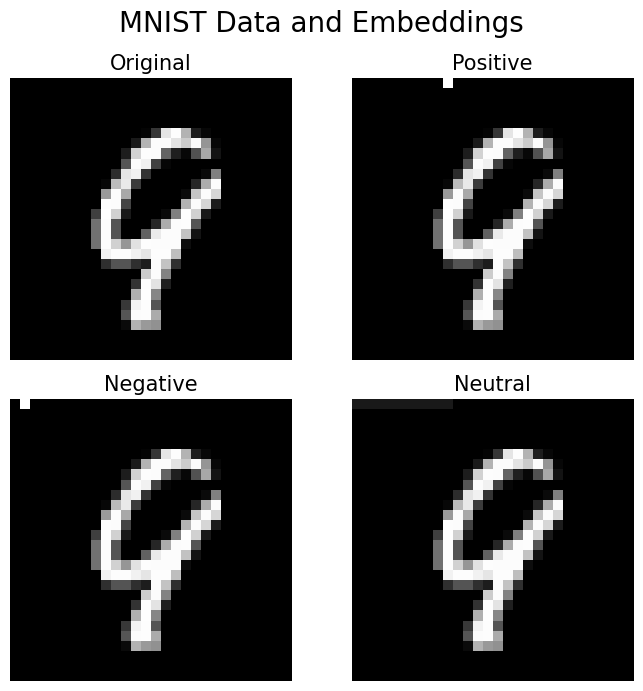

In [ ]:
# Load the MNIST dataset for visualization purposes
viz_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Select a random index from the dataset and ensure the label is 9
random_index = random.randint(0, len(viz_dataset) - 1)  # Generate a random index
image, label = viz_dataset[random_index]  # Retrieve the image and its label
while label != 9:  # Repeat until a sample with label 9 is found
    random_index = random.randint(0, len(viz_dataset) - 1)
    image, label = viz_dataset[random_index]

# Convert the image tensor to a 2D NumPy array for further manipulation
X = image.squeeze().numpy()

# Save the original image
X_orig = X.copy()

# Create the positive example by modifying the image with the correct label
X_pos = X.copy()
X_pos[0, label] = 1  # Highlight the pixel corresponding to the correct label

# Create the negative example by modifying the image with an incorrect label
X_neg = X.copy()
incorrect_label = 1  # Select an incorrect label (in this case, fixed to 1)
X_neg[0, incorrect_label] = 1  # Highlight the pixel corresponding to the incorrect label

# Create the neutral example by distributing equal weights across all labels
X_neu = X.copy()
X_neu[0, :10] = 0.1  # Assign uniform values to simulate neutrality across all labels

# Prepare data and labels for visualization
X_data = [X_orig, X_pos, X_neg, X_neu]
X_labels = ["Original", "Positive", "Negative", "Neutral"]

# Visualize the original, positive, negative, and neutral examples in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_data[i], cmap='gray')  # Display the image in grayscale
    ax.set_title(X_labels[i], fontsize=15)  # Set the title corresponding to each example
    ax.axis('off')  # Remove axes for a cleaner visualization

# Add an overarching title and adjust the layout for better appearance
plt.suptitle("MNIST Data and Embeddings", fontsize=20)
plt.tight_layout()
plt.show()

Note carefully (it is hard to see) that the neutral data has 10 gray boxes in the first 10 indices.

## Datasets and Dataloaders

As a single image from MNIST can be used as positive, negative, and neutral data, it will be helpful to easily access these datatypes as we loop through the training/testing process. This is the main purpose of the below code, but we summarize the main details below.

* Gets a given partition of the data (i.e. train, validation, or test sets)
* Alters the __getitem__ magic method so that object[i] now returns a positive sample, a negative sample, a neutral sample, and the corresponding correct label

In [ ]:
def get_MNIST_partition(configs, partition):
    """
    Retrieves a specific partition of the MNIST dataset.

    Args:
        configs (object): Configuration object containing input parameters.
        partition (str): The dataset partition to retrieve ('train', 'val', 'test').

    Returns:
        torch.utils.data.Dataset: The requested MNIST dataset partition.

    Raises:
        ValueError: If an invalid partition is specified.
    """
    if partition in ['train', 'val']:
        # Load the training data (full MNIST dataset)
        dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    elif partition == 'test':
        # Load the test data
        dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    else:
        raise ValueError("Invalid partition. Must be 'train', 'val', or 'test'.")

    if partition == 'train':
        # Use 80% of the data for training
        dataset = torch.utils.data.Subset(dataset, range(int(0.8 * len(dataset))))
    elif partition == 'val':
        # Use the remaining 20% of the data for validation
        dataset = torch.utils.data.Subset(dataset, range(int(0.8 * len(dataset)), len(dataset)))

    return dataset

class FF_MNIST_Dataset(torch.utils.data.Dataset):
    """
    A custom dataset class for MNIST, designed for supervised learning tasks.

    Attributes:
        partition (str): The dataset partition ('train', 'val', or 'test').
        configs (object): Configuration object containing input parameters.
        dataset (torch.utils.data.Dataset): The MNIST dataset partition.
        num_classes (int): The number of classes in the dataset.
        posneg_scheme (str): The scheme for generating positive/negative examples.
    """
    def __init__(self, configs, partition):
        """
        Initializes the dataset object.

        Args:
            configs (object): Configuration object containing input parameters.
            partition (str): The dataset partition ('train', 'val', or 'test').
        """
        self.partition = partition
        self.configs = configs
        self.dataset = get_MNIST_partition(configs, partition)
        self.num_classes = configs.input.num_classes
        self.posneg_scheme = configs.input.posneg_scheme

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Retrieves a data item by index.

        Args:
            idx (int): The index of the data item.

        Returns:
            tuple: A tuple of positive, negative, neutral examples and the label.

        Raises:
            ValueError: If an invalid posneg scheme is provided.
        """
        if self.posneg_scheme == 'supervised':
            return self.get_supervised_item(idx)
        else:
            raise ValueError("Invalid posneg scheme provided")

    def get_supervised_item(self, idx):
        """
        Generates positive, negative, and neutral examples for a given index.

        Args:
            idx (int): The index of the data item.

        Returns:
            tuple: Positive example, negative example, neutral example, and the label.
        """
        image, label = self.dataset[idx]

        # Generate a positive label example
        pos = image.clone()
        pos[:, 0, label] = 1

        # Generate a negative label example
        incorrect_label = random.randint(0, self.num_classes - 1)
        while incorrect_label == label:
            incorrect_label = random.randint(0, self.num_classes - 1)

        neg = image.clone()
        neg[:, 0, incorrect_label] = 1

        # Generate a neutral label example
        neu = image.clone()
        neu[:, 0, :self.num_classes] = 1 / self.num_classes

        return pos, neg, neu, label

def get_data(configs, partition):
    """
    Creates a DataLoader for the specified MNIST dataset partition.

    Args:
        configs (object): Configuration object containing input parameters.
        partition (str): The dataset partition ('train', 'val', or 'test').

    Returns:
        torch.utils.data.DataLoader: DataLoader for the specified dataset partition.
    """
    dataset = FF_MNIST_Dataset(configs, partition)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=configs.input.batch_size, shuffle=True, num_workers=4)
    return data_loader


## Model Architecture
This section outlines the key components and techniques employed in the model.

### Main Model for Feature Extraction
The main model consists of a sequence of linear layers, each followed by a custom ReLU activation function. These layers are designed to extract hierarchical features from the input data, forming the foundation for subsequent tasks.

### Downstream Classification Model
The downstream classification model is a single linear layer that maps the output of the feature extraction model to a vector of logits, representing class probabilities. For the MNIST dataset, this layer produces logits of size 10, corresponding to the 10 possible digit classes.

### Custom Goodness Function
Inspired by Geoffrey Hinton’s work, the model supports customizable goodness functions. While Hinton advocates for the sum of squares or the negative sum of squares as measures of activation quality, this implementation generalizes the approach by allowing the goodness function to be specified as a parameter during model instantiation. This flexibility facilitates experimentation with alternative metrics for evaluating activation quality.

### Peer Normalization
Hinton highlights the importance of controlling the average activity of hidden units to promote stability and learning efficiency. Peer normalization achieves this by encouraging the average activity of hidden units in a layer to converge toward a target value, defined as the running mean of their past average activities.

The peer normalization loss, referred to as peer_loss, is computed as: $\sum_i (\mu_i - x_{ij})^2$

where
* $\mu_i$ is the average activity across all hidden units in layer $i$
* $h_{ij}$ is the activity of the $j$-th hidden unit in layer $i$.

$\text{peer_loss} = \sum_j (\mu_i - h_{ij})^2$
where:

This loss acts as a regularization term, weighted by a small scalar hyperparameter (e.g., 0.03 in the MNIST case). Empirical results suggest that encouraging mean activities to be "similar, but not too similar" enhances model performance by balancing uniformity and diversity in hidden unit activations.

### Layer Normalization
Layer normalization ensures consistency in activation magnitudes across all hidden units within a layer by normalizing their values. This is achieved by either:

Subtracting the mean and dividing by the standard deviation, or
Dividing by the norm of the activations to enforce unit magnitude.
In this implementation, layer normalization is applied between layers, helping the model maintain stability and allowing the goodness function to evaluate patterns reliably without being influenced by scale differences. For a detailed discussion on layer normalization, refer [here](https://arxiv.org/pdf/1607.06450).

### Additional Key Features
Detachment from the Computation Graph: After processing data through a layer, the activations are detached from the computation graph. This prevents backpropagation through every layer, reducing computational overhead and promoting modularity in the model's learning process.

Input to the Downstream Classifier: The input to the downstream classification model aggregates activations from all hidden layers except the first. This approach enhances classification performance by incorporating features extracted at various levels of the hierarchy.

In [ ]:
class FFModel(torch.nn.Module):
    """
    A feedforward neural network model with support for peer normalization,
    a goodness function, and a downstream classifier for MNIST-like datasets.
    """

    def __init__(self, configs, goodness_fn, act_fn):
        """
        Initializes the model.

        Args:
            configs (object): Configuration object containing model parameters.
            goodness_fn (function): Function to calculate goodness of activation layers.
        """
        super(FFModel, self).__init__()

        self.configs = configs
        self.goodness_fn = goodness_fn

        # Main model: A stack of linear layers for feature extraction
        self.model = nn.ModuleList([nn.Linear(784, self.configs.model.hidden_dim)])
        for _ in range(self.configs.model.num_layers - 1):
            self.model.append(nn.Linear(self.configs.model.hidden_dim, self.configs.model.hidden_dim))
        self.model.to(self.configs.device)

        # Activation function with full gradient (custom implementation)
        self.act_fn = act_fn

        # Downstream classification model: Maps features to class probabilities
        self.classification_model = nn.Sequential(
            nn.Linear(self.configs.model.hidden_dim * (self.configs.model.num_layers - 1), 10, bias=False)
        )
        self.classification_model.to(self.configs.device)

        # Loss functions for feedforward learning and classification
        self.ff_loss = nn.BCEWithLogitsLoss()
        self.classification_loss = nn.CrossEntropyLoss()

        # Running means for peer normalization (one per layer)
        self.running_means = [
            torch.zeros(self.configs.model.hidden_dim, device=self.configs.device) + 0.5
            for _ in range(self.configs.model.num_layers)
        ]

        # Initialize model weights
        self._init_weights()

    def _init_weights(self):
        """Initializes the weights and biases of the layers."""
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                # Initialize weights with a normal distribution and biases to zero
                nn.init.normal_(layer.weight, mean=0, std=1 / math.sqrt(layer.weight.shape[0]))
                nn.init.zeros_(layer.bias)
        for layer in self.classification_model:
            if isinstance(layer, nn.Linear):
                nn.init.zeros_(layer.weight)

    ############################################################################
    ####### Where the Magic of the FF happens ##################################
    ############################################################################
    def forward(self, inputs):
        """
        Forward pass of the model.

        Args:
            inputs (tuple): Contains positive, negative, neutral examples, and labels.

        Returns:
            dict: Metadata including losses and metrics.
        """
        # Initialize a dictionary to store losses and metrics
        metadata = {
            "Loss": torch.zeros(1, device=self.configs.device),
            "Peer Normalization": torch.zeros(1, device=self.configs.device)
        }

        # Separate inputs and transfer them to the specified device
        pos, neg, neu, label = inputs
        pos, neg, neu, label = pos.to(self.configs.device), neg.to(self.configs.device), neu.to(self.configs.device), label.to(self.configs.device)

        # Concatenate positive and negative samples for processing
        z = torch.cat([pos, neg], dim=0)
        posneg_labels = torch.zeros(z.shape[0], device=self.configs.device)
        posneg_labels[: self.configs.input.batch_size] = 1

        # Flatten input samples and apply layer normalization
        z = z.reshape(z.shape[0], -1)
        z = self._layer_norm(z)

        # Process data through each layer of the model
        for idx, layer in enumerate(self.model):
            z = layer(z)  # Linear transformation
            z = self.act_fn(z)  # Apply activation function

            # Calculate peer normalization loss if enabled
            if self.configs.model.peer_normalization > 0:
                peer_loss = self._calc_peer_normalization_loss(idx, z)
                metadata["Peer Normalization"] += peer_loss
                metadata["Loss"] += self.configs.model.peer_normalization * peer_loss

            # Calculate feedforward loss and accuracy
            ff_loss, ff_acc = self._calc_ff_loss_acc(z, posneg_labels)
            metadata[f"loss_layer_{idx}"] = ff_loss
            metadata[f"ff_accuracy_layer_{idx}"] = ff_acc
            metadata["Loss"] += ff_loss

            z = z.detach()  # Detach gradient for the next layer

            z = self._layer_norm(z)  # Apply layer normalization

        # Pass data through the downstream classification model
        metadata = self.forward_downstream_classifier(neu, label, metadata)

        return metadata

    def _layer_norm(self, z, eps=1e-8):
        """Applies layer normalization."""
        return z / (torch.sqrt(torch.mean(z ** 2, dim=-1, keepdim=True)) + eps)

    def _calc_peer_normalization_loss(self, idx, z):
        """
        Calculates the peer normalization loss for a given layer.

        Args:
            idx (int): Index of the layer.
            z (torch.Tensor): Activations of the layer.

        Returns:
            torch.Tensor: The calculated peer normalization loss.
        """
        mean_activity = torch.mean(z[: self.configs.input.batch_size], dim=0)

        # Update running mean
        self.running_means[idx] = self.running_means[idx].detach() * \
            self.configs.model.momentum + mean_activity * (1 - self.configs.model.momentum)

        # Calculate the peer normalization loss
        peer_loss = (torch.mean(self.running_means[idx]) - self.running_means[idx]) ** 2
        return torch.mean(peer_loss)

    def _calc_ff_loss_acc(self, z, labels):
        """
        Calculates the feedforward loss and accuracy.

        Args:
            z (torch.Tensor): Activations from the current layer.
            labels (torch.Tensor): Labels for positive/negative samples.

        Returns:
            tuple: The loss and accuracy.
        """
        goodness = self.goodness_fn(z)  # Compute the goodness
        logits = goodness - z.shape[1]  # Adjust logits
        ff_loss = self.ff_loss(logits, labels.float())  # Binary cross-entropy loss

        with torch.no_grad():
            ff_acc = (torch.sum((torch.sigmoid(logits) > 0.5) == labels) / z.shape[0]).item()

        return ff_loss, ff_acc

    def forward_downstream_classifier(self, neu, label, metadata=None, ):
        """
        Forward pass through the downstream classification model.

        Args:
            neu (torch.Tensor): Neutral input examples.
            label (torch.Tensor): Ground truth labels.
            metadata (dict, optional): Existing metadata dictionary.

        Returns:
            dict: Updated metadata including classification loss and accuracy.
        """
        if metadata is None:
            metadata = {"Loss": torch.zeros(1, device=self.configs.device)}

        neu = neu.reshape(neu.shape[0], -1)
        neu = self._layer_norm(neu)

        # Collect intermediate outputs for the classifier
        input_to_classifier = []
        with torch.no_grad():
            for idx, layer in enumerate(self.model):
                neu = layer(neu)
                neu = self.act_fn(neu)
                neu = self._layer_norm(neu)

                if idx >= 1:
                    input_to_classifier.append(neu)

        # Concatenate inputs and pass through the classification model
        input_to_classifier = torch.cat(input_to_classifier, dim=-1).detach()
        output = self.classification_model(input_to_classifier)

        # Stabilize logits and calculate loss
        output = output - torch.max(output, dim=-1, keepdim=True)[0]
        classification_loss = self.classification_loss(output, label)

        with torch.no_grad():
            classification_accuracy = (torch.sum(torch.argmax(output, dim=-1) == label) / label.size(0)).item()

        # Update metadata
        metadata["Loss"] += classification_loss
        metadata["classification_loss"] = classification_loss
        metadata["classification_accuracy"] = classification_accuracy

        return metadata

class ReLU_full_grad(torch.autograd.Function):
    """ ReLU activation function that passes through the gradient irrespective of its input value. """

    @staticmethod
    def forward(ctx, input):
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone()

## Training and Validation

The below code has typical functions for training/testing/validating the network.

In [ ]:
def train(configs, model, optimizer):
    train_loader = get_data(configs, "train")

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(configs.training.epochs):

        for batch in train_loader:
            optimizer.zero_grad()

            metadata = model(batch)
            metadata["Loss"].backward()

            optimizer.step()

        train_losses.append(metadata["Loss"].item())
        train_accuracies.append(metadata["classification_accuracy"])

        print(f"Epoch: {epoch:>3}, "
            f"Loss: {metadata['Loss'].item():>10.6f}, "
            f"Accuracy: {metadata['classification_accuracy']:.2%}")

        if epoch % configs.training.val_idx == 0:
            val_loss, val_acc = validate_or_test(configs, model, "val")
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

    return model, train_losses, train_accuracies, val_losses, val_accuracies


def validate_or_test(configs, model, partition, epoch=None):
    data_loader = get_data(configs, partition)
    losses, accs = [], []

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            _, _, neu, label = batch
            neu, label = neu.to(configs.device), label.to(configs.device)

            metadata = model.forward_downstream_classifier(neu, label)
            losses.append(metadata["Loss"].item())
            accs.append(metadata["classification_accuracy"])

    loss, acc = np.mean(losses), np.mean(accs)
    print(f"Partition: {partition:>3}, "
      f"Loss: {metadata['Loss'].item():>10.6f}, "
      f"Accuracy: {metadata['classification_accuracy']:.2%}")

    model.train()
    return loss, acc

## Configurations

### Notes on configurations.



*   Models were all trained on Colab's GPUs, which was done for computational necessity
*   Minibatches were of size 100
*   Peer normalization constant of 0.03 was used. This was also the constant used by Sindy Löwe in her implementation. We didn't have great intuition/reason to choose otherwise.
*   The optimizer we used was SGD with a momentum of 0.9, as mentioned in Pratik's notes as a common choice.
*   The models were 3 layers deep. This is relatively shallow, but generally sufficient on toy datasets like MNIST.
*   Each layer had 1000 hidden units.
*   The learning rate for the main model was 0.001

In [ ]:
config_dict = {
    'seed': 42,
    'device': 'cuda',

    'input': {
        'path': './datasets',
        'batch_size': 100,
        'num_classes': 10,
        'posneg_scheme': 'supervised'
    },

    'model': {
        'peer_normalization': 0.03,
        'momentum': 0.9,  # Momentum to use for the running mean in peer normalization loss.

        'hidden_dim': 1000,
        'num_layers': 3
    },

    'training': {
        'epochs': 50,
        'learning_rate': 1e-3,
        'weight_decay': 3e-5,
        'momentum': 0.9,

        'downstream_learning_rate': 1e-2,
        'downstream_weight_decay': 3e-3,

        'val_idx': 5,
        'final_test': True
    },
  }

configs = OmegaConf.create(config_dict)

np.random.seed(configs.seed)
torch.manual_seed(configs.seed)

## Running the model

The below cell trains the network on the training data, validating every 5 epochs. A total of 50 epochs were run.

In [ ]:
goodness_fn = lambda x: torch.sum(x ** 2, dim=-1)
act_fn = ReLU_full_grad.apply
model = FFModel(configs, goodness_fn, act_fn)

main_model_params = [
    p
    for p in model.parameters()
    if all(p is not x for x in model.classification_model.parameters())
]
optimizer = torch.optim.SGD(
    [
        {
            "params": main_model_params,
            "lr": configs.training.learning_rate,
            "weight_decay": configs.training.weight_decay,
            "momentum": configs.training.momentum,
        },
        {
            "params": model.classification_model.parameters(),
            "lr": configs.training.downstream_learning_rate,
            "weight_decay": configs.training.downstream_weight_decay,
            "momentum": configs.training.momentum,
        },
    ]
)

model, train_losses, train_accuracies, val_losses, val_accuracies = train(configs, model, optimizer)

<ipython-input-22-307fcd4bf302>:2: DeprecationWarning: <class '__main__.ReLU_full_grad'> should not be instantiated. Methods on autograd functionsare all static, so you should invoke them on the class itself. Instantiating an autograd function will raise an error in a future version of PyTorch.
  act_fn = ReLU_full_grad()


Epoch:   0, Loss:  40.590023, Accuracy: 90.00%
Partition: val, Loss:   0.280787, Accuracy: 90.00%
Epoch:   1, Loss:  25.939865, Accuracy: 93.00%
Epoch:   2, Loss:  10.424588, Accuracy: 99.00%
Epoch:   3, Loss:  14.425217, Accuracy: 97.00%
Epoch:   4, Loss:   6.153278, Accuracy: 93.00%
Epoch:   5, Loss:  11.310230, Accuracy: 95.00%
Partition: val, Loss:   0.132534, Accuracy: 96.00%
Epoch:   6, Loss:   6.051235, Accuracy: 97.00%
Epoch:   7, Loss:   7.556978, Accuracy: 94.00%
Epoch:   8, Loss:   5.777133, Accuracy: 96.00%
Epoch:   9, Loss:   2.086134, Accuracy: 97.00%
Epoch:  10, Loss:   3.617522, Accuracy: 99.00%
Partition: val, Loss:   0.144272, Accuracy: 96.00%
Epoch:  11, Loss:   1.960249, Accuracy: 98.00%
Epoch:  12, Loss:   6.201233, Accuracy: 96.00%
Epoch:  13, Loss:   3.921248, Accuracy: 98.00%
Epoch:  14, Loss:   3.614838, Accuracy: 96.00%
Epoch:  15, Loss:   2.702178, Accuracy: 98.00%
Partition: val, Loss:   0.104256, Accuracy: 98.00%
Epoch:  16, Loss:   2.934987, Accuracy: 99.0

## Test Results

It is of interest to evaluate the model's classification accuracy and loss on the test set. As shown below, the model trained with FF acheived 99\% test accuracy. General convolutional neural networks with backpropagation achieve roughly the same results (see, for example, our first homework assignment).

In [ ]:
_, _ = validate_or_test(configs, model, 'test')

Partition: test, Loss:   0.031889, Accuracy: 99.00%


## Visualizing loss and accuracy

### Loss
Note that the loss and validation losses are not measured exactly the same, so it does not make sense to include them on the same plot. The training loss is computed as a sum of the goodness loss across each layer, the peer normalization loss, and the classification loss given by the downstream classification model. The validation loss is only given by the downstream classification model. Plots of these are separately still informative as they show general trends in decreasing loss, but do not necessarily show the same thing.

### Accuracy
The accuracy in both training and validation are determined by the downstream classification model - i.e. this is the accuracy in predicting the classes of various MNIST images.

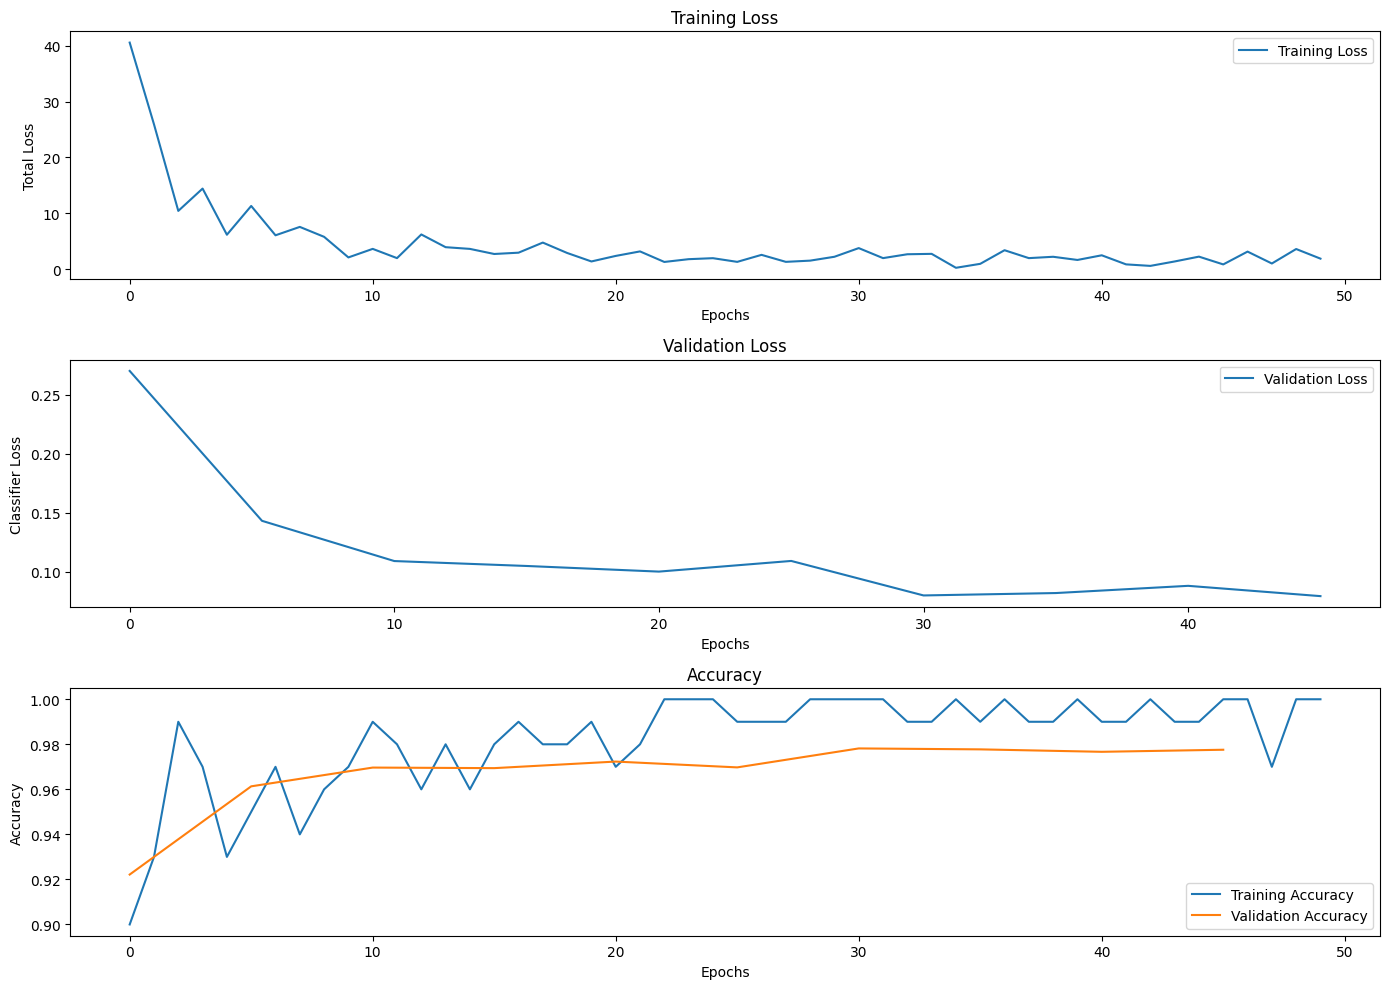

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.5)
val_domain = range(0, len(val_losses) * configs.training.val_idx, configs.training.val_idx)

## Plot loss
axs[0].plot(train_losses, label='Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Total Loss')
axs[0].set_title('Training Loss')
axs[0].legend()

axs[1].plot(val_domain, val_losses, label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Classifier Loss')
axs[1].set_title('Validation Loss')
axs[1].legend()

axs[2].plot(train_accuracies, label='Training Accuracy')
axs[2].plot(val_domain, val_accuracies, label='Validation Accuracy')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Accuracy')
axs[2].legend()

plt.tight_layout()
plt.show()


## Conclusions on the MNIST dataset

The application of the Forward-Forward algorithm to the MNIST dataset yielded a classification accuracy of approximately 99%. This result demonstrates the algorithm's efficacy in addressing this fundamental yet widely benchmarked image classification task. The high accuracy achieved highlights the algorithm's capacity to learn and generalize effectively in the context of handwritten digit recognition, serving as a promising validation of its potential in similar supervised learning settings.



# 3. Activation functions

It was proposed by Hinton that a potential avenue of future work could consider experimentation with activation functions. One that he suggests that could be interesting is the negative log of the density under a t-distribution.

We rerun our classification model on MNIST, considering these activiation functions:

* Relu
* Negative log of the density under a t-distribution
* Leaky Relu
* Swish: $x$sigmoid$(x)$
* Exponential Linear Unit (ELU)

## Why negative log of the density under a t-distribution?

The negative log density under a t-distribution is defined as:

$-\log f(x) = -\log\left(\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\sqrt{\nu \pi} \, \Gamma\left(\frac{\nu}{2}\right)} \left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu+1}{2}}\right)$

where $x$ is the input, $\nu$ is the degrees of freedom, and $\Gamma$ is the gamma function. Geoffrey Hinton may have considered the negative log density of a t-distribution as a candidate for an activation function in the Forward-Forward algorithm because it introduces nonlinearity while remaining robust to outliers. Unlike traditional activation functions like ReLU or sigmoid, the t-distribution's heavy tails allow it to handle large input values more gracefully. This could provide stability during training and potentially lead to more expressive feature representations. Additionally, the smooth gradient properties of the t-distribution’s negative log density may help avoid issues like vanishing or exploding gradients, making it a natural fit for the novel objectives of the Forward-Forward paradigm.


## Defining The Different activation functions

In [ ]:
import torch
import math

class TDistributionActivation(torch.autograd.Function):
    """
    T-distribution activation function: computes the negative log of the density under
    a t-distribution with a specified degrees of freedom (nu).
    """

    @staticmethod
    def forward(ctx, input, nu):
        """
        Forward pass of the activation function.

        Args:
            ctx (Context): Autograd context to save information for backward pass.
            input (torch.Tensor): Input tensor to the activation function.
            nu (float): Degrees of freedom for the t-distribution.

        Returns:
            torch.Tensor: Output tensor after applying the activation function.
        """

        # Compute the negative log-density of the t-distribution
        log_norm_const = torch.lgamma(torch.tensor((nu + 1) / 2)) - torch.lgamma(torch.tensor(nu / 2)) - 0.5 * torch.log(torch.tensor(nu * math.pi))
        neg_log_density = -log_norm_const + 0.5 * (nu + 1) * torch.log(1 + input**2 / nu)

        return neg_log_density

    @staticmethod
    def backward(ctx, grad_output):
        """
        Backward pass of the activation function.

        Args:
            ctx (Context): Autograd context to retrieve saved information.
            grad_output (torch.Tensor): Gradient of the loss with respect to the output.

        Returns:
            tuple: Gradient of the loss with respect to the input and nu.
        """
        return grad_output.clone(), None

def t_activation(input, nu=3):
    return TDistributionActivation.apply(input, nu)


In [ ]:
class LeakyReLU_full_grad(torch.autograd.Function):
    """ Leaky ReLU activation function that passes through the gradient irrespective of its input value. """
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input.clamp(min=0) + 0.01 * input.clamp(max=0)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        return grad_output.clone()

class ELU_full_grad(torch.autograd.Function):
    """ ELU activation function that passes through the gradient irrespective of its input value. """
    @staticmethod
    def forward(ctx, input):
        return input.clamp(min=0) + 0.01 * (torch.exp(input) - 1)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone()


class Swish_full_grad(torch.autograd.Function):
    """ Swish activation function that passes through the gradient irrespective of its input value. """
    @staticmethod
    def forward(ctx, input):
        return input * torch.sigmoid(input)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone()

Epoch:   0, Loss:  47.577812, Accuracy: 83.00%
Partition: val, Loss:   0.543566, Accuracy: 87.00%
Epoch:   1, Loss:  16.946415, Accuracy: 91.00%
Epoch:   2, Loss:  14.949703, Accuracy: 96.00%
Epoch:   3, Loss:  13.655483, Accuracy: 92.00%
Epoch:   4, Loss:   9.316680, Accuracy: 92.00%
Epoch:   5, Loss:  12.984469, Accuracy: 95.00%
Partition: val, Loss:   0.194014, Accuracy: 96.00%
Epoch:   6, Loss:   6.500072, Accuracy: 95.00%
Epoch:   7, Loss:  14.144380, Accuracy: 99.00%
Epoch:   8, Loss:   2.141434, Accuracy: 98.00%
Epoch:   9, Loss:   4.262334, Accuracy: 98.00%
Epoch:  10, Loss:   6.194429, Accuracy: 95.00%
Partition: val, Loss:   0.167913, Accuracy: 95.00%
Epoch:  11, Loss:   3.126088, Accuracy: 98.00%
Epoch:  12, Loss:   8.552472, Accuracy: 95.00%
Epoch:  13, Loss:   4.158399, Accuracy: 98.00%
Epoch:  14, Loss:   5.643248, Accuracy: 98.00%
Epoch:  15, Loss:   4.902882, Accuracy: 99.00%
Partition: val, Loss:   0.081266, Accuracy: 97.00%
Epoch:  16, Loss:   3.682782, Accuracy: 99.0

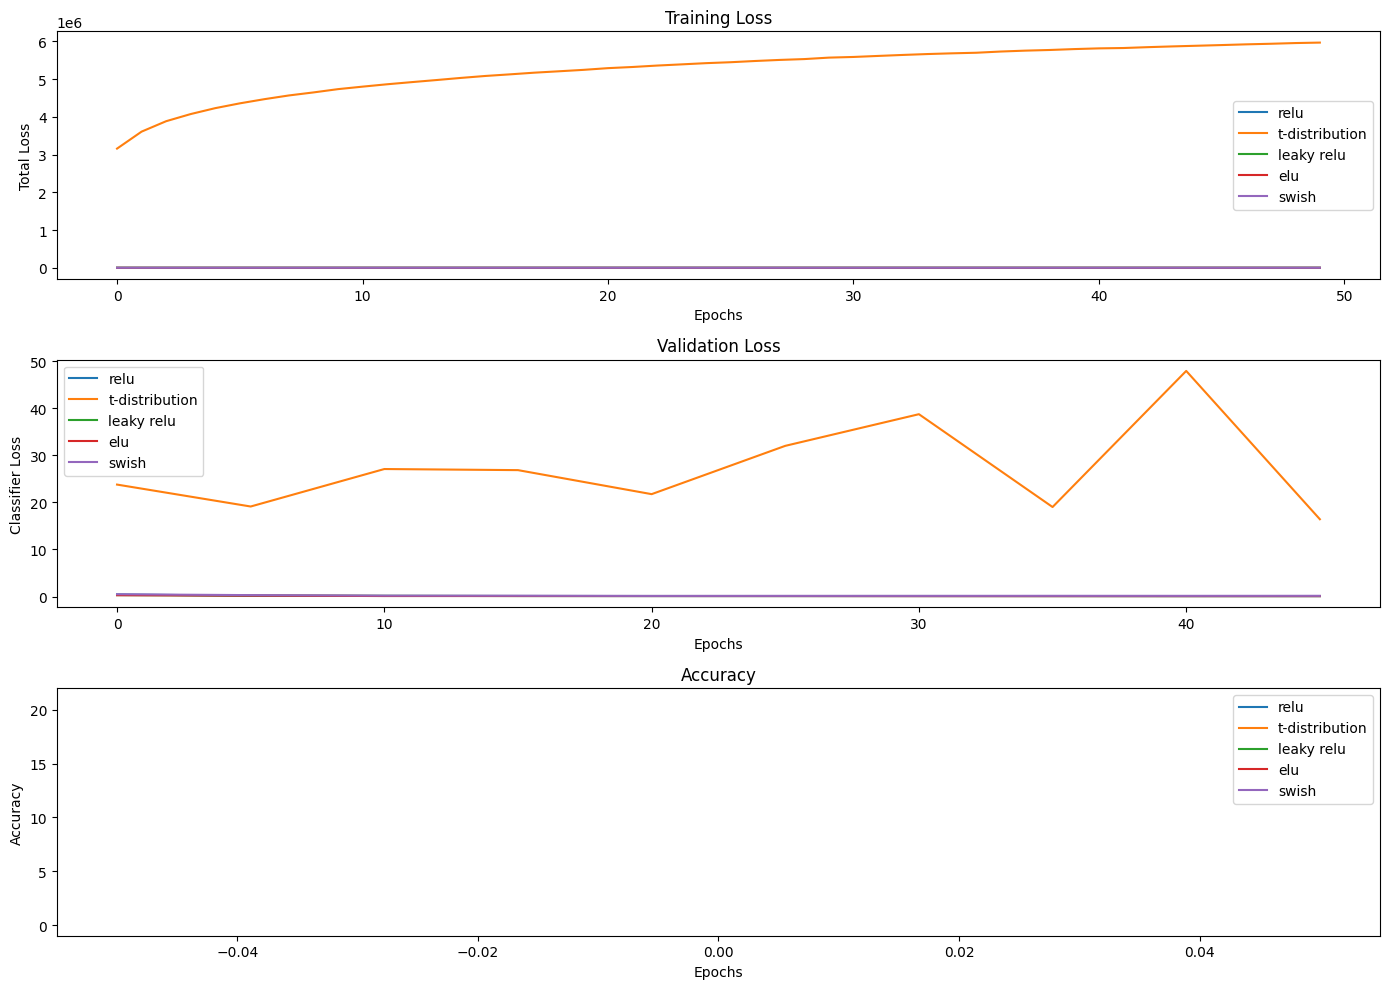

In [ ]:
act_fn_list = [ReLU_full_grad.apply, t_activation, LeakyReLU_full_grad.apply, ELU_full_grad.apply, Swish_full_grad.apply]
goodness_fn = lambda x: torch.sum(x ** 2, dim=-1)
d = {0: 'relu', 1: 't-distribution', 2: 'leaky relu', 3: 'elu', 4: 'swish'}

results = {}
for i, act_fn in enumerate(act_fn_list):
    results[d[i]] = []
    model = FFModel(configs, goodness_fn, act_fn)
    main_model_params = [
        p
        for p in model.parameters()
        if all(p is not x for x in model.classification_model.parameters())
    ]
    optimizer = torch.optim.SGD(
    [
        {
            "params": main_model_params,
            "lr": configs.training.learning_rate,
            "weight_decay": configs.training.weight_decay,
            "momentum": configs.training.momentum,
        },
        {
            "params": model.classification_model.parameters(),
            "lr": configs.training.downstream_learning_rate,
            "weight_decay": configs.training.downstream_weight_decay,
            "momentum": configs.training.momentum,
        },
    ]
    )
    model, train_losses, train_accuracies, val_losses, val_accuracies = train(configs, model, optimizer)
    test_loss, test_acc = validate_or_test(configs, model, 'test')
    results[d[i]] = [train_losses, train_accuracies, val_losses, val_accuracies, test_loss, test_acc]



## Visualizing Results

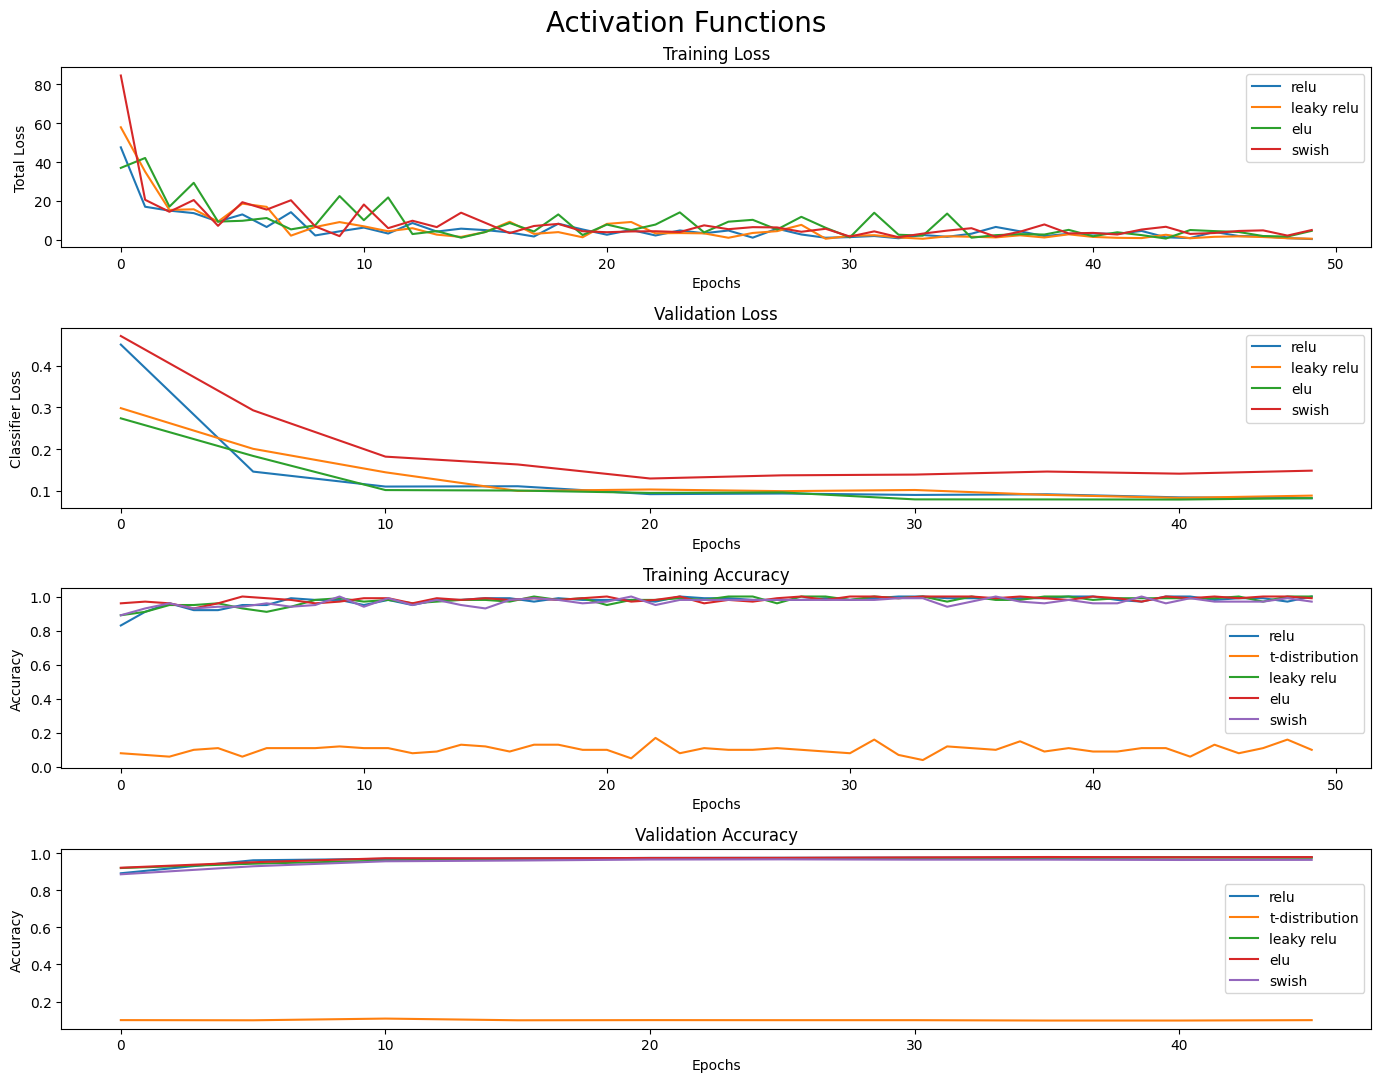

In [ ]:
# Now plot train losses and classification accuracies for each
fig, axs = plt.subplots(4, 1, figsize=(14, 11))
plt.subplots_adjust(hspace=0.5)
val_domain = range(0, len(val_losses) * configs.training.val_idx, configs.training.val_idx)

for i, act_fn in enumerate(act_fn_list):
    if i != 1:
        axs[0].plot(results[d[i]][0], label=d[i])
        axs[1].plot(val_domain, results[d[i]][2], label=d[i])
    axs[2].plot(results[d[i]][1], label=d[i])
    axs[3].plot(val_domain, results[d[i]][3], label=d[i])

axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Total Loss')
axs[0].set_title('Training Loss')
axs[0].legend()

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Classifier Loss')
axs[1].set_title('Validation Loss')
axs[1].legend()

axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Training Accuracy')
axs[2].legend()

axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('Accuracy')
axs[3].set_title('Validation Accuracy')
axs[3].legend()

plt.suptitle("Activation Functions", fontsize=20)

plt.tight_layout()
plt.show()

### Note on the visualization

Note that neither the train nor validation losses were plotted for the t-distribution activation function. This is because losses were unproportionately high for this activation function compared to the others, which skewed the visual of loss curves.

## Results on the test set

In [ ]:
for i, act_fn in enumerate(act_fn_list):
    print(f"{d[i]} test loss: {results[d[i]][4]}")
    print(f"{d[i]} test acc: {results[d[i]][5]}")
    print()

relu test loss: 0.06575651498045772
relu test acc: 0.9813999688625336

t-distribution test loss: 20.977874088287354
t-distribution test acc: 0.1031999972090125

leaky relu test loss: 0.07313595660962165
leaky relu test acc: 0.978499966263771

elu test loss: 0.06830331997014583
elu test acc: 0.9806999677419662

swish test loss: 0.10088475402444601
swish test acc: 0.9736999690532684



## Conclusions about activation functions

The t-distribution activation function performed terribly - this could be an implementation error, the wrong choice in degrees of freedom (nu), or it could just be very unfit for the problem.

Otherwise, each activation function performed well and nothing seemed to outperform relu or given any significant reason that another activation function is more preferrable.

# 4. Supervised Learning on Fashion MNIST

We've been able to replicate performance on MNIST images, could the supervised method work well for other image classification tasks? We explore this question by considering the Fashion MNIST dataset - still relatively simple, but definitely a step up in complexity from MNIST.

The labels in FashionMNIST are

* 0: T-shirt/top
* 1: Trouser
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

## Negative, Positive, and Neutral Data for Fashion MNIST.

As we still have labels 0-9 and are still working with 28x28 grayscale images, we approach this problem the same way as on MNIST. Thus positive images have the correct numerical embedding, negative data have an incorrect embedding, and neutral data has has a value of 0.1 at each of the first ten pixel locations. Let's visualize these.

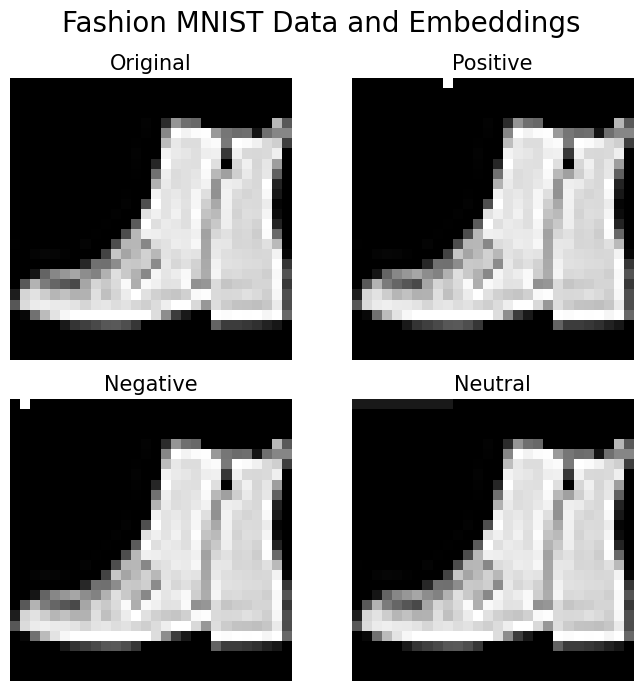

In [ ]:
# Load the MNIST dataset for visualization purposes
viz_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Select a random index from the dataset and ensure the label is 9
random_index = random.randint(0, len(viz_dataset) - 1)  # Generate a random index
image, label = viz_dataset[random_index]  # Retrieve the image and its label
while label != 9:  # Repeat until a sample with label 9 is found
    random_index = random.randint(0, len(viz_dataset) - 1)
    image, label = viz_dataset[random_index]

# Convert the image tensor to a 2D NumPy array for further manipulation
X = image.squeeze().numpy()

# Save the original image
X_orig = X.copy()

# Create the positive example by modifying the image with the correct label
X_pos = X.copy()
X_pos[0, label] = 1  # Highlight the pixel corresponding to the correct label

# Create the negative example by modifying the image with an incorrect label
X_neg = X.copy()
incorrect_label = 1  # Select an incorrect label (in this case, fixed to 1)
X_neg[0, incorrect_label] = 1  # Highlight the pixel corresponding to the incorrect label

# Create the neutral example by distributing equal weights across all labels
X_neu = X.copy()
X_neu[0, :10] = 0.1  # Assign uniform values to simulate neutrality across all labels

# Prepare data and labels for visualization
X_data = [X_orig, X_pos, X_neg, X_neu]
X_labels = ["Original", "Positive", "Negative", "Neutral"]

# Visualize the original, positive, negative, and neutral examples in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_data[i], cmap='gray')  # Display the image in grayscale
    ax.set_title(X_labels[i], fontsize=15)  # Set the title corresponding to each example
    ax.axis('off')  # Remove axes for a cleaner visualization

# Add an overarching title and adjust the layout for better appearance
plt.suptitle("Fashion MNIST Data and Embeddings", fontsize=20)
plt.tight_layout()
plt.show()

## Alterations to the implementation.

Below we alter the existing FF model so that it can handle the Fashion MNIST Data. It is big picture still the same algorithm.

In [ ]:
def get_FashionMNIST_partition(configs, partition):
    """
    Retrieves a specific partition of the MNIST dataset.

    Args:
        configs (object): Configuration object containing input parameters.
        partition (str): The dataset partition to retrieve ('train', 'val', 'test').

    Returns:
        torch.utils.data.Dataset: The requested MNIST dataset partition.

    Raises:
        ValueError: If an invalid partition is specified.
    """
    if partition in ['train', 'val']:
        # Load the training data (full MNIST dataset)
        dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    elif partition == 'test':
        # Load the test data
        dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    else:
        raise ValueError("Invalid partition. Must be 'train', 'val', or 'test'.")

    if partition == 'train':
        # Use 80% of the data for training
        dataset = torch.utils.data.Subset(dataset, range(int(0.8 * len(dataset))))
    elif partition == 'val':
        # Use the remaining 20% of the data for validation
        dataset = torch.utils.data.Subset(dataset, range(int(0.8 * len(dataset)), len(dataset)))

    return dataset

class FF_FashionMNIST_Dataset(torch.utils.data.Dataset):
    """
    A custom dataset class for MNIST, designed for supervised learning tasks.

    Attributes:
        partition (str): The dataset partition ('train', 'val', or 'test').
        configs (object): Configuration object containing input parameters.
        dataset (torch.utils.data.Dataset): The MNIST dataset partition.
        num_classes (int): The number of classes in the dataset.
        posneg_scheme (str): The scheme for generating positive/negative examples.
    """
    def __init__(self, configs, partition):
        """
        Initializes the dataset object.

        Args:
            configs (object): Configuration object containing input parameters.
            partition (str): The dataset partition ('train', 'val', or 'test').
        """
        self.partition = partition
        self.configs = configs
        self.dataset = get_FashionMNIST_partition(configs, partition)
        self.num_classes = configs.input.num_classes
        self.posneg_scheme = configs.input.posneg_scheme

    def __len__(self):
        """
        Returns the number of samples in the dataset.

        Returns:
            int: Number of samples.
        """
        return len(self.dataset)

    def __getitem__(self, idx):
        """
        Retrieves a data item by index.

        Args:
            idx (int): The index of the data item.

        Returns:
            tuple: A tuple of positive, negative, neutral examples and the label.

        Raises:
            ValueError: If an invalid posneg scheme is provided.
        """
        if self.posneg_scheme == 'supervised':
            return self.get_supervised_item(idx)
        else:
            raise ValueError("Invalid posneg scheme provided")

    def get_supervised_item(self, idx):
        """
        Generates positive, negative, and neutral examples for a given index.

        Args:
            idx (int): The index of the data item.

        Returns:
            tuple: Positive example, negative example, neutral example, and the label.
        """
        image, label = self.dataset[idx]

        # Generate a positive label example
        pos = image.clone()
        pos[:, 0, label] = 1

        # Generate a negative label example
        incorrect_label = random.randint(0, self.num_classes - 1)
        while incorrect_label == label:
            incorrect_label = random.randint(0, self.num_classes - 1)

        neg = image.clone()
        neg[:, 0, incorrect_label] = 1

        # Generate a neutral label example
        neu = image.clone()
        neu[:, 0, :self.num_classes] = 1 / self.num_classes

        return pos, neg, neu, label

def get_Fashion_data(configs, partition):
    """
    Creates a DataLoader for the specified MNIST dataset partition.

    Args:
        configs (object): Configuration object containing input parameters.
        partition (str): The dataset partition ('train', 'val', or 'test').

    Returns:
        torch.utils.data.DataLoader: DataLoader for the specified dataset partition.
    """
    dataset = FF_FashionMNIST_Dataset(configs, partition)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=configs.input.batch_size, shuffle=True, num_workers=4)
    return data_loader


def train_Fashion(configs, model, optimizer):
    train_loader = get_Fashion_data(configs, "train")

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(configs.training.epochs):

        for batch in train_loader:
            optimizer.zero_grad()

            metadata = model(batch)
            metadata["Loss"].backward()

            optimizer.step()

        train_losses.append(metadata["Loss"].item())
        train_accuracies.append(metadata["classification_accuracy"])

        print(f"Epoch: {epoch:>3}, "
            f"Loss: {metadata['Loss'].item():>10.6f}, "
            f"Accuracy: {metadata['classification_accuracy']:.2%}")

        if epoch % configs.training.val_idx == 0:
            val_loss, val_acc = validate_or_test_Fashion(configs, model, "val")
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

    return model, train_losses, train_accuracies, val_losses, val_accuracies


def validate_or_test_Fashion(configs, model, partition, epoch=None):
    data_loader = get_Fashion_data(configs, partition)
    losses, accs = [], []

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            _, _, neu, label = batch
            neu, label = neu.to(configs.device), label.to(configs.device)

            metadata = model.forward_downstream_classifier(neu, label)
            losses.append(metadata["Loss"].item())
            accs.append(metadata["classification_accuracy"])

    loss, acc = np.mean(losses), np.mean(accs)
    print(f"Partition: {partition:>3}, "
      f"Loss: {metadata['Loss'].item():>10.6f}, "
      f"Accuracy: {metadata['classification_accuracy']:.2%}")

    model.train()
    return loss, acc


## Running the model

In [ ]:
goodness_fn = lambda x: torch.sum(x ** 2, dim=-1)
act_fn = ReLU_full_grad.apply
model = FFModel(configs, goodness_fn, act_fn)

main_model_params = [
    p
    for p in model.parameters()
    if all(p is not x for x in model.classification_model.parameters())
]
optimizer = torch.optim.SGD(
    [
        {
            "params": main_model_params,
            "lr": configs.training.learning_rate,
            "weight_decay": configs.training.weight_decay,
            "momentum": configs.training.momentum,
        },
        {
            "params": model.classification_model.parameters(),
            "lr": configs.training.downstream_learning_rate,
            "weight_decay": configs.training.downstream_weight_decay,
            "momentum": configs.training.momentum,
        },
    ]
)

model, train_losses, train_accuracies, val_losses, val_accuracies = train_Fashion(configs, model, optimizer)

Epoch:   0, Loss:  82.018372, Accuracy: 67.00%
Partition: val, Loss:   1.255335, Accuracy: 75.00%
Epoch:   1, Loss: 215.152649, Accuracy: 64.00%
Epoch:   2, Loss:  70.292534, Accuracy: 82.00%
Epoch:   3, Loss:  72.353500, Accuracy: 78.00%
Epoch:   4, Loss:  43.438736, Accuracy: 81.00%
Epoch:   5, Loss:  72.003494, Accuracy: 72.00%
Partition: val, Loss:   0.978556, Accuracy: 76.00%
Epoch:   6, Loss:  47.586834, Accuracy: 87.00%
Epoch:   7, Loss:  52.182629, Accuracy: 78.00%
Epoch:   8, Loss:  72.821739, Accuracy: 84.00%
Epoch:   9, Loss:  42.401257, Accuracy: 78.00%
Epoch:  10, Loss:  35.398907, Accuracy: 85.00%
Partition: val, Loss:   0.672717, Accuracy: 84.00%
Epoch:  11, Loss:  39.225338, Accuracy: 82.00%
Epoch:  12, Loss:  52.329357, Accuracy: 74.00%
Epoch:  13, Loss:  46.452866, Accuracy: 77.00%
Epoch:  14, Loss:  22.847609, Accuracy: 78.00%
Epoch:  15, Loss:  35.087700, Accuracy: 87.00%
Partition: val, Loss:   0.821584, Accuracy: 79.00%
Epoch:  16, Loss:  38.499863, Accuracy: 78.0

## Evaluate on the test set

In [ ]:
_, _ = validate_or_test_Fashion(configs, model, 'test')

Partition: test, Loss:   0.322120, Accuracy: 90.00%


## Visualize train/validation loss and accuracy

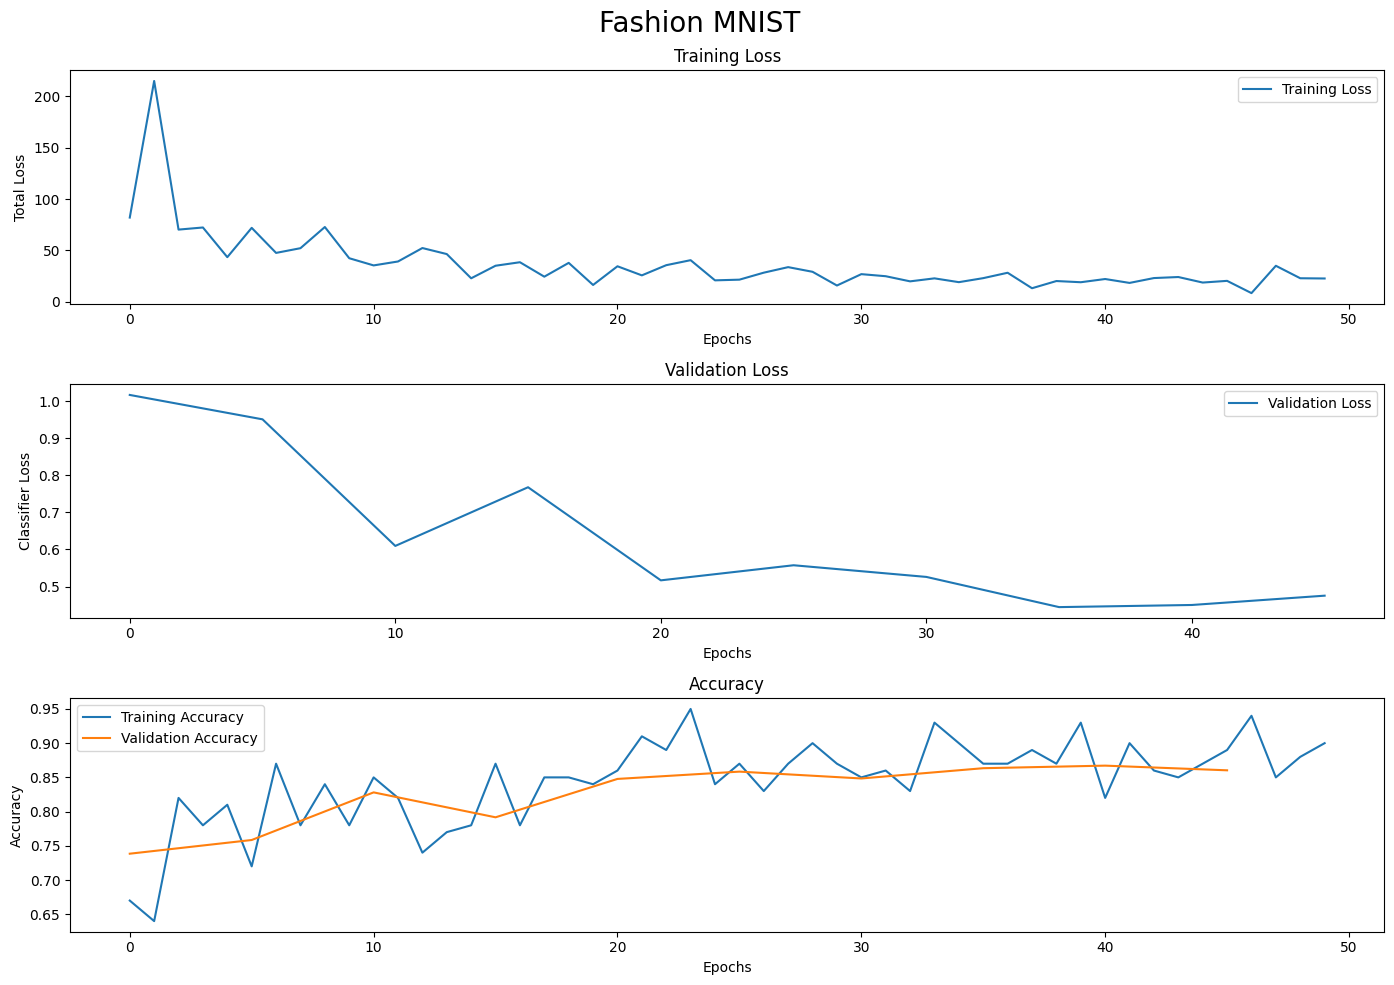

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.5)
val_domain = range(0, len(val_losses) * configs.training.val_idx, configs.training.val_idx)

## Plot loss
axs[0].plot(train_losses, label='Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Total Loss')
axs[0].set_title('Training Loss')
axs[0].legend()

axs[1].plot(val_domain, val_losses, label='Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Classifier Loss')
axs[1].set_title('Validation Loss')
axs[1].legend()

axs[2].plot(train_accuracies, label='Training Accuracy')
axs[2].plot(val_domain, val_accuracies, label='Validation Accuracy')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[2].set_title('Accuracy')
axs[2].legend()

plt.suptitle("Fashion MNIST", fontsize=20)
plt.tight_layout()
plt.show()


## Conclusions about FF on Fashion MNIST

FF ended up reporting a 90\% accuracy on the test set of Fashion MNIST. This is ok, but even simple convolutional networks with backpropagation can get above this (93\% or 94\%). State of the art models acheive upwards of 98\%.

Thus, the FF algorithm demonstrates that it has potential, but will not be replacing backpropagation anytime soon, at least for image classification on Fashion MNIST. Future work on this particular problem could explore implementing a deeper network or using other methods that are problem specific to Fashion MNIST.

# 5. Negative Data using Hybrid Data

We adapt our Dataloader class to generate negative data as hybrid data as described by Hinton. We create a random mask which is smoothed and then applied to a sample. The negative of this mask is then applied to another sample and the two are placed together to create a "hybrid" sample which serves as our negative data.

The larger chunks are preserved to help the model learn larger features.

## Code for new negative sample generation

In [ ]:
def get_MNIST_partition(opt, partition):
    """Given a partition in ['train', 'val', test'], this function returns a dataloader
    with the relevant data."""
    mnist = torchvision.datasets.MNIST(
        opt.input.path,
        train=partition in ["train", "val"],
        download=True,
        transform=torchvision.transforms.ToTensor(),
    )

    if partition == "train":
        mnist = torch.utils.data.Subset(mnist, range(50000))  # Take the first 50,000 pts to be training data

    elif partition == "val":
        mnist = torch.utils.data.Subset(mnist, range(50000, 60000))  # Take the next 10,000 points as the validation data

    return mnist

class FF_MNIST(torch.utils.data.Dataset):
    """Dataset for FF MNIST for a given partition."""
    def __init__(self, opt, partition, num_classes=10):
        self.opt = opt
        self.mnist = get_MNIST_partition(opt, partition)
        self.num_classes = num_classes
        self.uniform_label = torch.ones(self.num_classes).to(opt.device) / self.num_classes

    def __getitem__(self, index):
        """When object[i] is called, it will return 3 samples with associated class label
        and return these as dictionaries."""
        pos_sample, neg_sample = self._generate_sample(index)

        inputs = {
            "pos_images": pos_sample,
            "neg_images": neg_sample,
        }

        return inputs

    def __len__(self):
        return len(self.mnist)

    def _get_pos_sample(self, sample, class_label):
        one_hot_label = torch.nn.functional.one_hot(
            torch.tensor(class_label), num_classes=self.num_classes
        )
        pos_sample = sample.clone()
        pos_sample[:, 0, : self.num_classes] = one_hot_label
        return pos_sample

    def _get_neg_sample(self, index):
        sample1, class_label1 = self.mnist[index]
        index2 = np.random.randint(0, len(self.mnist))
        sample2, class_label2 = self.mnist[index2]
        while class_label1 == class_label2:
            index2 = np.random.randint(0, len(self.mnist))
            sample2, class_label2 = self.mnist[index2]

        sample1 = sample1.to(opt.device)
        sample2 = sample2.to(opt.device)

        # Kernel reshaped for convolution
        kernel = torch.tensor([1 / 4, 1 / 2, 1 / 4], dtype=torch.float32, device=self.opt.device).view(1, 1, -1)

        # Generate random mask on GPU
        mask = torch.rand((1, 28, 28), device=self.opt.device)

        # Convolve mask on GPU
        for _ in range(4):
            mask = F.conv2d(mask, kernel.unsqueeze(0), padding=(0, 1), stride=1, groups=1)
            mask = F.conv2d(mask, kernel.unsqueeze(0).transpose(2, 3), padding=(1, 0), stride=1, groups=1)

        # Threshold the blurred mask
        mask = (mask > 0.5).float()

        # Create hybrid image
        reverse_mask = 1 - mask
        hybrid_image = sample1 * mask + sample2 * reverse_mask
        return hybrid_image

    def _generate_sample(self, index):
        # Get MNIST sample.
        sample, class_label = self.mnist[index]
        pos_sample = self._get_pos_sample(sample, class_label)
        neg_sample = self._get_neg_sample(index)
        return pos_sample, neg_sample

Include generated negative data and loss over training graphs for 50 epochs

## Example output for negative data

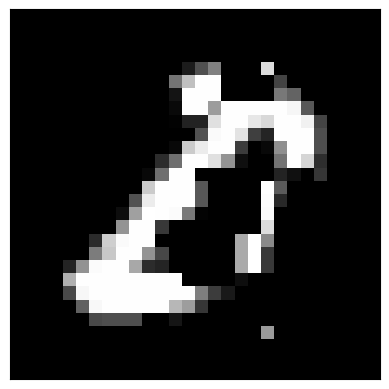

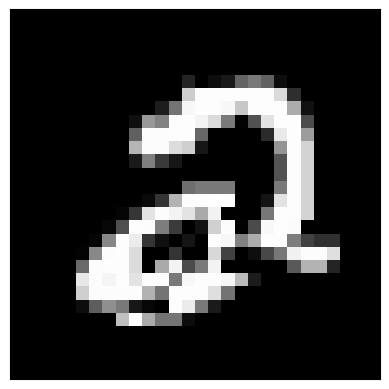

In [ ]:
config_dict = {
    'seed': 42,
    'device': 'cpu',

    'input': {
        'path': './datasets',
        'batch_size': 100
    },

    'model': {
        'peer_normalization': 0.03,
        'momentum': 0.9,  # Momentum to use for the running mean in peer normalization loss.

        'hidden_dim': 1000,
        'num_layers': 3
    },

    'training': {
        'epochs': 50,
        'learning_rate': 1e-3,
        'weight_decay': 3e-5,
        'momentum': 0.9,

        'downstream_learning_rate': 1e-2,
        'downstream_weight_decay': 3e-3,

        'val_idx': 5,
        'final_test': True
    },
  }

opt = OmegaConf.create(config_dict)

np.random.seed(opt.seed)
torch.manual_seed(opt.seed)

ldr = FF_MNIST(opt, 'train')
img = ldr._get_neg_sample(2)
plt.imshow(img.squeeze(0).cpu(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

img = ldr._get_neg_sample(5)
plt.imshow(img.squeeze(0).cpu(), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

Because this is an unsupervised task, rather than the supervised tasks done above, we refactor much of the training code and track the loss over time

## Refactored Training Code for Unsupervised Learning

In [ ]:
class FF_model(torch.nn.Module):
    """The model trained with Forward-Forward (FF) for unsupervised learning."""

    def __init__(self, opt):
        super(FF_model, self).__init__()

        self.opt = opt
        self.num_channels = [self.opt.model.hidden_dim] * self.opt.model.num_layers
        self.act_fn = ReLU_full_grad()

        # Initialize the encoder.
        self.encoder = nn.ModuleList([nn.Linear(784, self.num_channels[0])])
        for i in range(1, len(self.num_channels)):
            self.encoder.append(nn.Linear(self.num_channels[i - 1], self.num_channels[i]))

        # Initialize the decoder.
        self.decoder = nn.ModuleList()
        for i in range(len(self.num_channels) - 1, 0, -1):
            self.decoder.append(nn.Linear(self.num_channels[i], self.num_channels[i - 1]))
        self.decoder.append(nn.Linear(self.num_channels[0], 784))

        # Loss for reconstruction
        self.reconstruction_loss = nn.MSELoss()

        # Initialize weights.
        self._init_weights()

    def _init_weights(self):
        for m in self.encoder.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=1 / math.sqrt(m.weight.shape[0]))
                torch.nn.init.zeros_(m.bias)

        for m in self.decoder.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.normal_(m.weight, mean=0, std=1 / math.sqrt(m.weight.shape[0]))
                torch.nn.init.zeros_(m.bias)

    def _layer_norm(self, z, eps=1e-8):
        return z / (torch.sqrt(torch.mean(z ** 2, dim=-1, keepdim=True)) + eps)

    def forward(self, inputs):
        scalar_outputs = {
            "Loss": torch.zeros(1, device=self.opt.device),
        }

        z = torch.cat([inputs["pos_images"], inputs["neg_images"]], dim=0)  # (2*batch, 28, 28)
        posneg_labels = torch.zeros(z.shape[0], device=self.opt.device)  # (2*batch, )
        posneg_labels[: self.opt.input.batch_size] = 1  # (2*batch, )  positive images have label 1, negatives have label 0

        z = z.reshape(z.shape[0], -1)  # (2*batch, 28**2)
        test = z.clone()
        z = self._layer_norm(z)

        # Encoder
        for idx, layer in enumerate(self.encoder):
            z = layer(z)
            z = self.act_fn.apply(z)
            z = self._layer_norm(z)

        # Decoder
        for idx, layer in enumerate(self.decoder):
            z = layer(z)
            if idx < len(self.decoder) - 1:  # Apply activation except on the output layer
                z = self.act_fn.apply(z)
            z = self._layer_norm(z)

        # Reconstruction loss
        recon_loss = self.reconstruction_loss(z, test)
        scalar_outputs["Loss"] += recon_loss

        return scalar_outputs


class ReLU_full_grad(torch.autograd.Function):
    """ ReLU activation function that passes through the gradient irrespective of its input value. """

    @staticmethod
    def forward(ctx, input):
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone()


In [ ]:
def train(opt, model, optimizer):
    start_time = time.time()
    train_loader = get_data(opt, "train")
    num_steps_per_epoch = len(train_loader)

    log_train = []
    log_val = []
    for epoch in range(opt.training.epochs):
        train_results = defaultdict(float)
        optimizer = update_learning_rate(optimizer, opt, epoch)

        for inputs in train_loader:
            inputs = preprocess_inputs(opt, inputs)

            optimizer.zero_grad()

            scalar_outputs = model(inputs)
            scalar_outputs["Loss"].backward()

            optimizer.step()

            train_results = log_results(
                train_results, scalar_outputs, num_steps_per_epoch
            )
        log_train.append(train_results)

        print_results("train", time.time() - start_time, train_results, epoch)
        start_time = time.time()

        # Validate.
        if epoch % opt.training.val_idx == 0 and opt.training.val_idx != -1:
            val_res = validate_or_test(opt, model, "val", epoch=epoch)
            log_val.append(val_res)
    return model, log_train, log_val


def validate_or_test(opt, model, partition, epoch=None):
    test_time = time.time()
    test_results = defaultdict(float)

    data_loader = get_data(opt, partition)
    num_steps_per_epoch = len(data_loader)

    model.eval()
    print(partition)
    with torch.no_grad():
        for inputs in data_loader:
            inputs = preprocess_inputs(opt, inputs)

            scalar_outputs = model(inputs)
            test_results = log_results(
                test_results, scalar_outputs, num_steps_per_epoch
            )

    print_results(partition, time.time() - test_time, test_results, epoch=epoch)
    model.train()

    return test_results


def main():
    model, optimizer = get_model_and_optimizer(opt)
    model, log_train, log_val = train(opt, model, optimizer)

    validate_or_test(opt, model, "test")
    return model, log_train, log_val


## Loss Over 50 Epochs

In [ ]:
model, log_train, log_val = main()
train_loss = [log['Loss'] for log in log_train]
val_loss = [log['Loss'] for log in log_val]

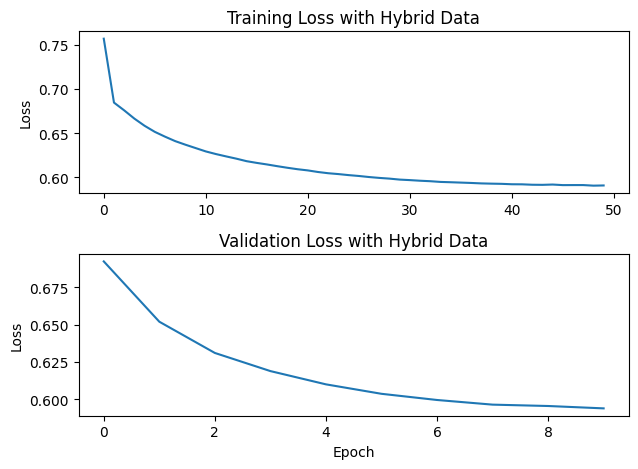

In [ ]:
plt.subplot(211)
plt.plot(train_loss)
plt.title("Training Loss with Hybrid Data")
plt.ylabel("Loss")
plt.subplot(212)
plt.plot(val_loss)
plt.title("Validation Loss with Hybrid Data")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

# 6. Goodness Function Exploration

A goodness function is a measure used to evaluate the quality of a layer's output for a given input. The purpose of the goodness function is to distinguish between positive and negative data.

At each layer in the network the weights are put into the goodness function and that becomes the objective which we try to maximize for positive data and minimize for negative data. This allows the network to adjust its weights without the need for backpropagation. Hinton suggests using the sum of squared activities of neurons in a layer as one possible goodness function, but alludes to the fact that other functions are possible. By optimizing this function, the network learns to produce high goodness values for real data and low goodness values for negative data, effectively training the model to recognize and differentiate between the two types of inputs.

### Functions We Investigate:

- Sum of Sqaures of Nueral Activities
  $G(\mathbf{h}) = \sum_i h_i^2 - \theta$

- Log-Sum-Exp Approximation
$G(\mathbf{h}) = \log\left(\sum_i \exp(h_i^2)\right)$

- Norm-Based Functions (p = 1.5, p = 4)
$G(\mathbf{h}) = \left(\sum_i |h_i|^p\right)^{1/p}$

- Soft-Thresholded Sum of Squares
$G(\mathbf{h}) = \sum_i \sigma(h_i) \cdot h_i^2, \quad \sigma(h_i) = \frac{1}{1 + \exp(-h_i)}$

- Quadratic Penalized Activation
$G(\mathbf{h}) = \sum_i (h_i - \mu)^2$

In order to compare the effect of the selection of goodness function on training, we used the forward forward implementation provided by Loewe_x on the MNIST dataset, albiet with the code altered so that different goodness functions can be passed in as a parameter. So save time and space, we ran the code once and hardcoded in the outputs of classification loss and classification accuracy.

Below is some of the code that we altered from the original implementation.

###Implementation

In [ ]:
config_dict = {
    'seed': 42,
    'device': 'cpu',

    'input': {
        'path': './datasets',
        'batch_size': 100
    },

    'model': {
        'peer_normalization': 0.03,
        'momentum': 0.9,  # Momentum to use for the running mean in peer normalization loss.

        'hidden_dim': 1000,
        'num_layers': 3
    },

    'training': {
        'epochs': 50,
        'learning_rate': 1e-3,
        'weight_decay': 3e-5,
        'momentum': 0.9,

        'downstream_learning_rate': 1e-2,
        'downstream_weight_decay': 3e-3,

        'val_idx': 10,
        'final_test': True
    },
  }

opt = OmegaConf.create(config_dict)

np.random.seed(opt.seed)
torch.manual_seed(opt.seed)

In [ ]:
class FF_model(torch.nn.Module):
    """The model trained with Forward-Forward (FF)."""

    def __init__(self, opt):
        super(FF_model, self).__init__()

        self.opt = opt
        self.num_channels = [self.opt.model.hidden_dim] * self.opt.model.num_layers
        self.act_fn = ReLU_full_grad()

        # Initialize the model.
        self.model = nn.ModuleList([nn.Linear(784, self.num_channels[0])])
        for i in range(1, len(self.num_channels)):
            self.model.append(nn.Linear(self.num_channels[i - 1], self.num_channels[i]))

        # Initialize forward-forward loss.
        self.ff_loss = nn.BCEWithLogitsLoss()

        # Initialize peer normalization loss.
        self.running_means = [
            torch.zeros(self.num_channels[i], device=self.opt.device) + 0.5
            for i in range(self.opt.model.num_layers)
        ]

        # Initialize downstream classification loss.
        channels_for_classification_loss = sum(
            self.num_channels[-i] for i in range(self.opt.model.num_layers - 1)
        )
        self.linear_classifier = nn.Sequential(
            nn.Linear(channels_for_classification_loss, 10, bias=False)
        )
        self.classification_loss = nn.CrossEntropyLoss()

        # Initialize weights.
        self._init_weights()

    def _init_weights(self):
        for m in self.model.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.normal_(
                    m.weight, mean=0, std=1 / math.sqrt(m.weight.shape[0])
                )
                torch.nn.init.zeros_(m.bias)

        for m in self.linear_classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.zeros_(m.weight)

    def _layer_norm(self, z, eps=1e-8):
        return z / (torch.sqrt(torch.mean(z ** 2, dim=-1, keepdim=True)) + eps)

    def _calc_peer_normalization_loss(self, idx, z):
        # Only calculate mean activity over positive samples.
        mean_activity = torch.mean(z[:self.opt.input.batch_size], dim=0)

        self.running_means[idx] = self.running_means[
            idx
        ].detach() * self.opt.model.momentum + mean_activity * (
            1 - self.opt.model.momentum
        )

        peer_loss = (torch.mean(self.running_means[idx]) - self.running_means[idx]) ** 2
        return torch.mean(peer_loss)

    def _calc_ff_loss(self, z, labels, goodness_func):
        goodness = goodness_func(z)  # Dynamically apply the goodness function
        logits = goodness - z.shape[1]  # Subtract threshold
        ff_loss = self.ff_loss(logits, labels.float())  # Apply sigmoid and BCEloss

        with torch.no_grad():
            ff_accuracy = (
                torch.sum((torch.sigmoid(logits) > 0.5) == labels)
                / z.shape[0]
            ).item()
        return ff_loss, ff_accuracy


    def forward(self, inputs, labels, goodness_func):
        scalar_outputs = {
            "Loss": torch.zeros(1, device=self.opt.device),
            "Peer Normalization": torch.zeros(1, device=self.opt.device),
        }

        z = torch.cat([inputs["pos_images"], inputs["neg_images"]], dim=0)  # (2*batch, 28, 28)
        posneg_labels = torch.zeros(z.shape[0], device=self.opt.device)  # (2*batch, )
        posneg_labels[: self.opt.input.batch_size] = 1

        z = z.reshape(z.shape[0], -1)  # Flatten
        z = self._layer_norm(z)

        for idx, layer in enumerate(self.model):
            z = layer(z)
            z = self.act_fn.apply(z)

            if self.opt.model.peer_normalization > 0:
                peer_loss = self._calc_peer_normalization_loss(idx, z)
                scalar_outputs["Peer Normalization"] += peer_loss
                scalar_outputs["Loss"] += self.opt.model.peer_normalization * peer_loss

            ff_loss, ff_accuracy = self._calc_ff_loss(z, posneg_labels, goodness_func)
            scalar_outputs[f"loss_layer_{idx}"] = ff_loss
            scalar_outputs[f"ff_accuracy_layer_{idx}"] = ff_accuracy
            scalar_outputs["Loss"] += ff_loss
            z = z.detach()

            z = self._layer_norm(z)

        scalar_outputs = self.forward_downstream_classification_model(
            inputs, labels, scalar_outputs=scalar_outputs
        )

        return scalar_outputs


    def forward_downstream_classification_model(
        self, inputs, labels, scalar_outputs=None,
    ):
        if scalar_outputs is None:
            scalar_outputs = {
                "Loss": torch.zeros(1, device=self.opt.device),
            }

        z = inputs["neutral_sample"]
        z = z.reshape(z.shape[0], -1)
        z = self._layer_norm(z)

        input_classification_model = []

        with torch.no_grad():
            for idx, layer in enumerate(self.model):
                z = layer(z)
                z = self.act_fn.apply(z)
                z = self._layer_norm(z)

                if idx >= 1:
                    input_classification_model.append(z)

        input_classification_model = torch.concat(input_classification_model, dim=-1)

        output = self.linear_classifier(input_classification_model.detach())
        output = output - torch.max(output, dim=-1, keepdim=True)[0]
        classification_loss = self.classification_loss(output, labels["class_labels"])
        classification_accuracy = get_accuracy(
            self.opt, output.data, labels["class_labels"]
        )

        scalar_outputs["Loss"] += classification_loss
        scalar_outputs["classification_loss"] = classification_loss
        scalar_outputs["classification_accuracy"] = classification_accuracy
        return scalar_outputs


class ReLU_full_grad(torch.autograd.Function):
    """ ReLU activation function that passes through the gradient irrespective of its input value. """

    @staticmethod
    def forward(ctx, input):
        return input.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.clone()


In [ ]:
def train_single_model(opt, model, optimizer, goodness_func):
    start_time = time.time()
    train_loader = get_data(opt, "train")
    num_steps_per_epoch = len(train_loader)

    progress = []  # Track accuracy over epochs

    for epoch in range(opt.training.epochs):
        train_results = defaultdict(float)
        optimizer = update_learning_rate(optimizer, opt, epoch)

        for inputs, labels in train_loader:
            inputs, labels = preprocess_inputs(opt, inputs, labels)

            optimizer.zero_grad()

            scalar_outputs = model(inputs, labels, goodness_func)
            scalar_outputs["Loss"].backward()

            optimizer.step()

            train_results = log_results(
                train_results, scalar_outputs, num_steps_per_epoch
            )

        progress.append((train_results["classification_loss"], train_results["classification_accuracy"]))  # Track accuracy for this epoch
        print_results("train", time.time() - start_time, train_results, epoch)
        start_time = time.time()

        # Validate.
        if epoch % opt.training.val_idx == 0 and opt.training.val_idx != -1:
            validate_or_test(opt, model, "val", epoch=epoch)

    return progress



def validate_or_test(opt, model, partition, epoch=None):
    test_time = time.time()
    test_results = defaultdict(float)

    data_loader = get_data(opt, partition)
    num_steps_per_epoch = len(data_loader)

    model.eval()
    print(partition)
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = preprocess_inputs(opt, inputs, labels)

            scalar_outputs = model.forward_downstream_classification_model(
                inputs, labels
            )
            test_results = log_results(
                test_results, scalar_outputs, num_steps_per_epoch
            )

    print_results(partition, time.time() - test_time, test_results, epoch=epoch)
    model.train()

In [ ]:
def main():
    goodness_functions = {
        "sum_of_squares": lambda z: torch.sum(z ** 2, dim=-1),
        "log_sum_exp": lambda z: torch.logsumexp(z ** 2, dim=-1),
        "norm_based15": lambda z: torch.sum(torch.abs(z) ** 1.5, dim=-1) ** (1 / 1.5),
        "norm_based4": lambda z: torch.sum(torch.abs(z) ** 4, dim=-1) ** (1 / 4),
        "soft_thresholded_sum_of_squares": lambda z: torch.sum(torch.sigmoid(z) * (z ** 2), dim=-1),
        "quadratic_penalized": lambda z: torch.sum((z - 0.5) ** 2, dim=-1),
    }

    progress_data = {}  # Store accuracy progress for each goodness function

    for name, goodness_func in goodness_functions.items():
        print(f"Training model with {name} goodness function...")

        # Create a fresh model and optimizer for each goodness function
        model, optimizer = get_model_and_optimizer(opt)

        # Train the model
        progress = train_single_model(opt, model, optimizer, goodness_func)

        # Store progress
        progress_data[name] = progress

    return progress_data

# progress_data = main()

In [ ]:
progress_data = {'sum_of_squares': [(0.6980045920610436, 0.8329799998775124), (0.31912139827758074, 0.9144200019836429), (0.2181452635005113, 0.9374400024414068), (0.17068308114260444, 0.9493200026750603), (0.1493046630397439, 0.9545200021266975), (0.13165496255643666, 0.9600200037956284), (0.11347856141254306, 0.9647600049972593), (0.10848282426036894, 0.9671800067424832), (0.09342928014788777, 0.9706800073385295), (0.08582918609399351, 0.9730000091791213), (0.07569276268128312, 0.9756000111103118), (0.06970250768773256, 0.9776800111532263), (0.06384942809306092, 0.9799000097513253), (0.060137571571860435, 0.9810200110673958), (0.06023306603915988, 0.9803400102853829), (0.05645307449204853, 0.9828600106239368), (0.05253452391223983, 0.9829600111246154), (0.049496424005366794, 0.9842400101423312), (0.048435421350644894, 0.9842200100421964), (0.0476268297813367, 0.9848200093507808), (0.04521111713279966, 0.9852600091695835), (0.04120822138793302, 0.9872400094270753), (0.03895672058127818, 0.9882200093269391), (0.03928018167125995, 0.9880600082874342), (0.035995215359842396, 0.9887200095653572), (0.036680635838420184, 0.9885000090599102), (0.03226059158076528, 0.9894400082826654), (0.029474528173799627, 0.9907400076389352), (0.029441941057331864, 0.9911600077152292), (0.027985217160545278, 0.9912800076007877), (0.02452732864452991, 0.9926000066995655), (0.023088963337009754, 0.993020006179813), (0.022086162335355753, 0.9933200062513385), (0.020439316982461597, 0.9939000055789983), (0.019380131551297367, 0.9946400048732785), (0.01715210996591487, 0.9947400048971201), (0.01713481140753719, 0.9951000046730071), (0.016021214496693574, 0.9956000041961692), (0.014843023871362673, 0.9963400034904502), (0.014855521123623467, 0.9963400034904503), (0.013918347937636997, 0.9964800032377266), (0.013276588307227957, 0.9968200030326865), (0.013012224911130032, 0.9969800028800986), (0.012435735975508568, 0.9971600027084371), (0.011862469368847075, 0.9977400021553056), (0.011431877628085198, 0.9976400022506732), (0.011321130503667528, 0.9976400022506734), (0.010748980844393376, 0.9978000020980854), (0.010808576204930422, 0.9978400020599381), (0.010486397537868475, 0.998140001773836)], 'log_sum_exp': [(4.5675421618223195, 0.4878599986806514), (4.4955415600538275, 0.5841399981155991), (6.566142522335059, 0.5599399992823594), (9.742601392507554, 0.5236599991843104), (13.33418032145501, 0.4991199994012711), (13.948319977045074, 0.4865199997499583), (15.755753254890454, 0.4703799997493622), (19.72742911052704, 0.43447999924421343), (22.071354042530075, 0.4163200001791116), (29.30350739812851, 0.3682199993170791), (32.16340360546113, 0.34083999906480344), (36.921743902206394, 0.32825999886542584), (36.10201077461244, 0.32621999998763174), (40.70588912677763, 0.29519999929144963), (24.865313416481012, 0.38507999920845065), (29.295609462261176, 0.2888999991863964), (15.610795755386347, 0.41621999769657864), (20.40432241344451, 0.3228799995444715), (13.00232161283494, 0.3869599984660744), (14.697040897369394, 0.33157999916747194), (13.965501609325413, 0.3145200000517071), (12.337290460586544, 0.3129600000753998), (14.93203596353531, 0.2695200003162028), (15.456000787734991, 0.22202000028640057), (10.275874824523937, 0.24626000050455327), (9.759654552459715, 0.2301000000908973), (9.887924556255335, 0.20948000032454736), (5.703027988910676, 0.23594000049680464), (5.6757673988342265, 0.2322200006917122), (6.245324747562408, 0.22282000030577198), (8.564650617599485, 0.19402000061795124), (6.501858847618103, 0.20776000045984985), (7.114413513660428, 0.21287999988347292), (2.4765972025394425, 0.2558400002121924), (3.8547404704093937, 0.2424000008553267), (2.47619139766693, 0.2615000005513432), (4.6154789969921035, 0.2356000005304815), (4.176370556116101, 0.22337999975308792), (2.20056173658371, 0.24924000009894387), (2.151260376930237, 0.26124000036716444), (2.092529981374741, 0.2720800013542177), (2.0552176992893214, 0.28514000123739247), (2.4441639320850372, 0.250680000387132), (2.972399368047717, 0.20123999972641451), (2.19005108332634, 0.24296000026166406), (2.537876134157181, 0.18605999994277955), (2.973662987232208, 0.10557999996095883), (3.2372267765998832, 0.10886000015214095), (2.396979889392854, 0.1156999999433757), (2.320596943855285, 0.124039999946952)], 'norm_based15': [(25.471497756958023, 0.1085599997825921), (25.127903232574454, 0.10457999995350843), (24.812483485221875, 0.10621999977156525), (25.804501056671157, 0.10878000007569796), (22.316255827903763, 0.11946000002697116), (20.316941608428937, 0.12289999992400405), (19.293679413795477, 0.13452000018581756), (17.568356124877933, 0.1522000000067056), (15.53839376544953, 0.17722000016272066), (13.519124393463121, 0.19050000038743015), (11.477690154075635, 0.20808000029623513), (9.118394806861875, 0.24646000065654486), (8.91481292915344, 0.2526000002175572), (6.546941463470463, 0.2917199997678401), (5.834678287982936, 0.3132600001692772), (6.654729088306431, 0.29498000019788756), (4.015454340696337, 0.37327999888360525), (3.8957471704483035, 0.3874599987417467), (2.778346725225447, 0.4369799979925155), (2.4435534026622796, 0.447019997946918), (2.9170151621103293, 0.4422199978381393), (2.543543703913691, 0.46871999812871223), (2.300141227006912, 0.4749999974370003), (1.7912495775222776, 0.5156999976187944), (1.9546561970710772, 0.5148799986988304), (1.6569703330993648, 0.5413799984157079), (1.7848599963188159, 0.524259997904301), (1.4512529582977294, 0.5625799993872647), (1.2131834361553189, 0.5979000002741816), (1.2005422550439837, 0.6097399989366533), (1.0882836440801622, 0.6292800005078318), (1.0132139493227001, 0.6508999994993211), (0.9970325806140906, 0.6534200014472009), (0.9531243039369582, 0.6727600008845328), (0.9358733838796611, 0.6746399998068804), (0.9091277960538864, 0.6900000022649763), (0.8966393563747409, 0.6921000002622602), (0.8503466053009033, 0.7145399990081783), (0.8399271826744084, 0.7174000017642959), (0.8120131543874742, 0.7293000003099435), (0.7888011234998701, 0.7411599997282025), (0.795886116743088, 0.7368400015830981), (0.7784539324045177, 0.7473200007677059), (0.7624982226490968, 0.752379997730254), (0.7524030435085296, 0.7607399985790251), (0.7349486334323883, 0.7706799989938727), (0.7262805423140528, 0.7759599968194947), (0.7206757308840761, 0.7775399963855728), (0.7127439538240439, 0.7830199993848788), (0.7041270174384111, 0.7896399980783452)], 'norm_based4': [(21.332820124387737, 0.16285999964177617), (26.400645694732656, 0.09937999975308778), (26.727938280105565, 0.10232000001892444), (25.640443677902205, 0.10021999980881799), (25.31410954856875, 0.1004800000265241), (25.379880132675165, 0.1026200000904501), (28.17354888534547, 0.10016000007092955), (26.794873931884755, 0.10099999988451601), (26.418537590026855, 0.10147999981418258), (25.185447420120237, 0.09901999987661843), (26.366191722869868, 0.10063999998569492), (25.504720218658445, 0.09953999976068748), (25.672551219940214, 0.09994000000879177), (23.278079620361336, 0.10083999990299351), (23.272519760131843, 0.10158000015467408), (25.0861134529114, 0.10105999999493363), (25.92346345520018, 0.09959999993443486), (24.173029209136963, 0.10193999972194441), (27.927643144607526, 0.09855999992415322), (24.55311339282991, 0.1010799999311567), (26.53103202438354, 0.09966000001505024), (25.623672852516183, 0.09903999986127024), (25.26236896419525, 0.10029999990761289), (26.46177641677857, 0.10124000004678965), (26.63824866485597, 0.10063999999687089), (25.044542884826654, 0.10085999990627176), (26.32372914886476, 0.10145999989286066), (25.59009448623656, 0.10035999990999693), (23.727039704322795, 0.09995999999344342), (20.10601754474637, 0.10196000003069654), (18.846731447219845, 0.09919999983906751), (17.283727101325994, 0.09910000003129253), (16.590545012474063, 0.09974000011384491), (14.075606275081642, 0.09879999986663479), (13.101024898529047, 0.1007799999304116), (13.213897027015692, 0.09908000002801413), (9.74609213638306, 0.09891999971121539), (7.191400605678555, 0.10013999982550748), (3.6357725253105144, 0.09978000009059913), (2.6599441227912886, 0.10122000018134722), (2.607077520370483, 0.1008200000412763), (2.521576832294465, 0.10424000000581145), (2.5204054059982313, 0.10095999972894788), (2.471554332733154, 0.10071999992430207), (2.466000690460208, 0.0999799999780954), (2.427374685287477, 0.10271999981999391), (2.4044759082794203, 0.10410000008344647), (2.3718391494751, 0.09935999985784295), (2.353055554389953, 0.10124000012874608), (2.337606143951418, 0.10401999987289312)], 'soft_thresholded_sum_of_squares': [(0.7103542867153876, 0.8270199999287727), (0.3048321206867691, 0.9147600021362299), (0.24322676511853916, 0.9324000015258802), (0.20553361176699414, 0.9426600025892274), (0.1601508747730403, 0.9535200017690695), (0.14587286685965972, 0.9575800024271063), (0.12104235841054482, 0.9646000049114282), (0.11325438638776546, 0.9658000060319962), (0.10177782670594752, 0.9699800075292639), (0.09048840920766811, 0.9724400087595044), (0.08910546600352964, 0.9727600075006542), (0.07636468395753751, 0.9762000089883855), (0.07159194825030864, 0.977440010547643), (0.06771173687418922, 0.9790400110483221), (0.06775052301026882, 0.9789600104093608), (0.0619454467697069, 0.9802600100040492), (0.058366430070716936, 0.9817800096273475), (0.05369499677885322, 0.9832600102424672), (0.05386094614048489, 0.9833200100660373), (0.051364652787335215, 0.9840200096368842), (0.04512808888056314, 0.9854000103473711), (0.04456956959096713, 0.9859200105667157), (0.041591729614418003, 0.9871400099992793), (0.04217239378881642, 0.9864400091171317), (0.0399907882937696, 0.9874400095939676), (0.03877814211341316, 0.9877400100231215), (0.03481487127952278, 0.9888000090122263), (0.032835674170288265, 0.9899800082445184), (0.03227646746800744, 0.9900600081682247), (0.03039744950993916, 0.9909200081825292), (0.02723641459108332, 0.992000006914142), (0.02610930156777616, 0.9916000076532402), (0.024057010973338042, 0.9927600065469773), (0.022037731120828546, 0.9932600061893496), (0.020907410111743956, 0.9943600049018885), (0.020053655377938417, 0.9940800056457549), (0.019276765137445175, 0.9944800052642849), (0.017269331465708092, 0.9953600044250513), (0.016294471049448464, 0.995580004096034), (0.016068167441291747, 0.995680003881457), (0.01535527276468929, 0.9959200037717845), (0.014899360502604396, 0.9962400035858179), (0.013589557070634325, 0.9968200030326865), (0.013100541685824281, 0.996920002937319), (0.0125160938736517, 0.9970400028228779), (0.012125079495366656, 0.9974200024604817), (0.011933170294389124, 0.9973200025558491), (0.01135339515923989, 0.9975200023651144), (0.011465469720074903, 0.9977000021934527), (0.011234622197924178, 0.9977200021743791)], 'quadratic_penalized': [(1.9185753432214263, 0.6804199993386855), (0.8642069397568709, 0.8057999994754789), (0.9293248987197881, 0.7880599995851513), (1.0139552315473566, 0.7844799993038167), (0.8800215858519084, 0.8007199989557255), (0.7832930672764777, 0.8052199983596793), (0.7114720208346842, 0.8339399986267082), (0.6955447282493107, 0.8229599983692159), (0.7081639822125437, 0.8334399989843357), (0.574869699031115, 0.8533799977302543), (0.5835968357920649, 0.8439999980926507), (0.5718642127513878, 0.8539999995231627), (0.6048853525817398, 0.8433399987220774), (0.5733863856196404, 0.8469199986457814), (0.5166162129640578, 0.8585999994277953), (0.5406683154404167, 0.854939998865127), (0.509794184446335, 0.8555599995851509), (0.5375618922710422, 0.855019998908042), (0.5494294591248031, 0.8462999987602227), (0.5378917534351346, 0.8433200002908695), (0.5411494191885003, 0.8470799986124034), (0.5297130538821223, 0.8519399991035458), (0.530830011814832, 0.8511999984979618), (0.5463037542700768, 0.8520799983739845), (0.5829744847416881, 0.8382799998521803), (0.5375733667314045, 0.8486799989938728), (0.5949515298604968, 0.835519999027251), (0.5053318835943933, 0.8506599998474121), (0.5374821534752844, 0.8410399972200387), (0.5348970198929311, 0.8405599961280815), (0.5276646116077901, 0.8419799987077707), (0.5333373531103129, 0.8401999979019146), (0.573250156342983, 0.8242799990177145), (0.5877017939090735, 0.8176999983787532), (0.5336950733363628, 0.8349999989271142), (0.5329806462526321, 0.8367799973487842), (0.5716948280930525, 0.8213799980878811), (0.580560647726059, 0.8195999976396545), (0.5715557640790939, 0.8168999972343427), (0.5930422283411024, 0.8108999996185295), (0.5910868906378745, 0.8136999982595423), (0.589645941317081, 0.811359997630119), (0.57554409044981, 0.8147399973869311), (0.5887719965577131, 0.8080999976396551), (0.5983552625179289, 0.8039999984502788), (0.6132273019552228, 0.7998799970149981), (0.6062662770748145, 0.8023199979066838), (0.6010930215120321, 0.8047599962949734), (0.6102908627986905, 0.8011599963903417), (0.6032198859453195, 0.8049799988269781)]}

### Loss and Accuracy Comparison

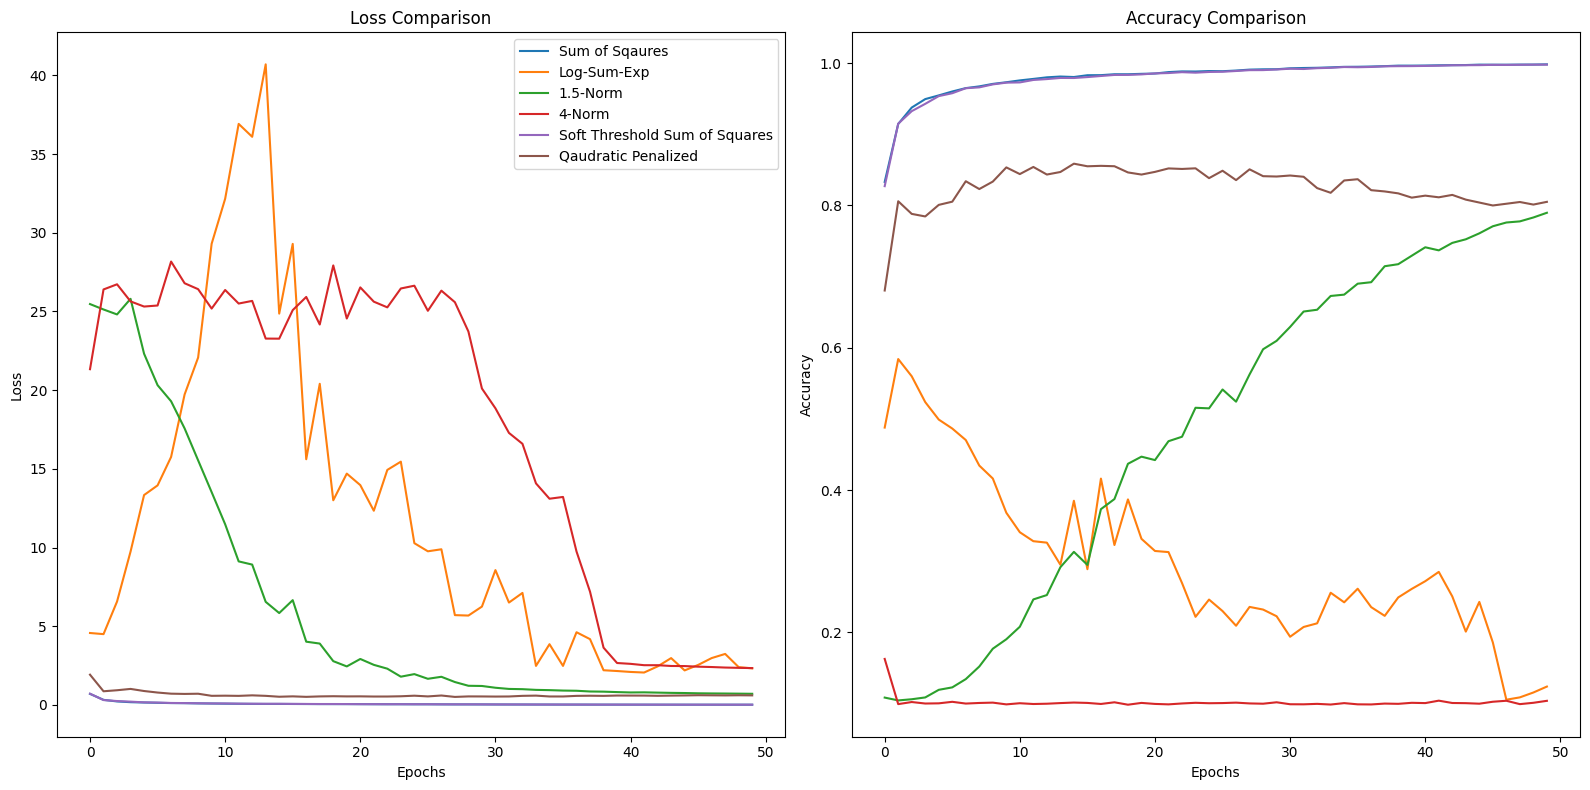

In [ ]:
# Create the figure for the plots
plt.figure(figsize=(16, 8))

func_names = {
    "sum_of_squares": 'Sum of Sqaures',
    "log_sum_exp": 'Log-Sum-Exp',
    "norm_based15": "1.5-Norm",
    "norm_based4": '4-Norm',
    "soft_thresholded_sum_of_squares": 'Soft Threshold Sum of Squares',
    "quadratic_penalized": 'Qaudratic Penalized',
}


# First subplot: Loss for all functions on the same plot
plt.subplot(1, 2, 1)
for k in progress_data:
    loss = [val[0] for val in progress_data[k]]
    plt.plot(loss, label=func_names[k])  # Plot all losses on the same plane
plt.title("Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Second subplot: Accuracy for all functions on the same plot
plt.subplot(1, 2, 2)
for k in progress_data:
    accuracy = [val[1] for val in progress_data[k]]
    plt.plot(accuracy, label=func_names[k])  # Plot all accuracies on the same plane
plt.title("Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

# Display the plots
plt.tight_layout()
plt.show()



# 7. Conclusion

#### Our venture into the world of the Forward Forward Algorithm has provided some interesting and promising results, but there is clearly more work to be done before this paradigm can replace backpropagation. Through the various scenarios we tested FF on, including MNIST, Fashion MNIST and unsupervised learning we see that networks trained with FF are able to learn the data fairly well, but not quite as well as the same networks trained with Backprop. We also did not notice any speedups in training time to make up for this decrease in accuracy.

#### With that being said, there is certainly a lot of promise for this algorithm considering its good performance with a fundamental change in the learning process. Our experiments show that there are a lot of alterations that can be made to the algorithm to improve performance (with goodness functions in particular being crucial to performance of the algorithm as a whole). With further research, we’re confident that significant breakthroughs will be made to allow FF to be used in a wide variety of deep networks as an alternative to the standard backpropagation.



# 8. Bibliography


1. Loewe, X. (2023). *Forward-Forward Algorithm Implementation*. GitHub repository.  
   Available at: [https://github.com/loeweX/Forward-Forward](https://github.com/loeweX/Forward-Forward)

2. Hinton, G. E. (2022). *The Forward-Forward Algorithm: Some Preliminary Investigations*.  
   arXiv preprint arXiv:2212.13345.  
   Available at: [https://arxiv.org/abs/2212.13345](https://arxiv.org/abs/2212.13345)

3. Alexander Ororbia & Ankur Mali (2023). *The Predictive Forward-Forward Algorithm*.  
   arXiv preprint arXiv:2301.01452.  
   Available at: [https://arxiv.org/abs/2301.01452](https://arxiv.org/abs/2301.01452)

4. Levine, A., & Yakar, T. (2023). *Training Neural Networks with Forward-Forward and its Variants*.  
   arXiv preprint arXiv:2305.12393.  
   Available at: [https://arxiv.org/pdf/2305.12393](https://arxiv.org/pdf/2305.12393)

